# Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from gan_protein_structural_requirements.models.ccc_progan_model import CNN_CCC_ProGAN_Model
from gan_protein_structural_requirements.models.seqtovec_model import SeqToVecModel
from gan_protein_structural_requirements.models import get_metrics, print_metrics
from gan_protein_structural_requirements.test import test_seqtovec

import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

# Data Analysis

In [5]:
train_dataset = torch.load("/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/save/train.pt")
test_dataset = torch.load("/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/data/save/test.pt")

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>], dtype=object)

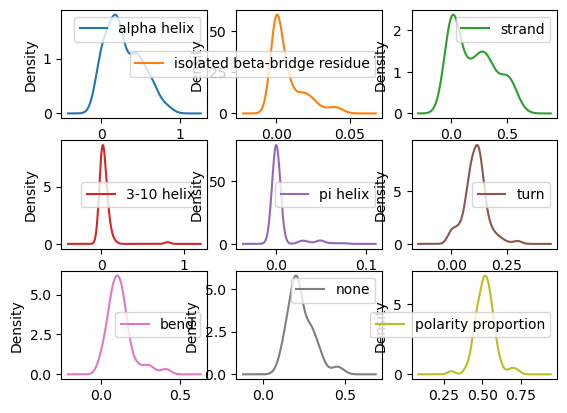

In [8]:
data = {"alpha helix":[],"isolated beta-bridge residue":[],"strand":[],"3-10 helix":[],"pi helix":[],"turn":[],"bend":[],"none":[],"polarity proportion":[],"sequence":[]}
for entry in train_dataset.X[:,0]:
    entry = entry.tolist()
    data["alpha helix"].append(entry[0])
    data["isolated beta-bridge residue"].append(entry[1])
    data["strand"].append(entry[2])
    data["3-10 helix"].append(entry[3])
    data["pi helix"].append(entry[4])
    data["turn"].append(entry[5])
    data["bend"].append(entry[6])
    data["none"].append(entry[7])
    data["polarity proportion"].append(entry[8])
for entry in train_dataset.Y:
    data["sequence"].append(entry.tolist())

raw_data = pd.DataFrame(data)

raw_features = raw_data.drop(columns=["sequence"])
fig, axes = plt.subplots(nrows=3, ncols=3)
raw_features.plot.kde(subplots=True, ax=axes)

## Model Training

### Sequence to Vector Model Training

In [15]:
def train(model, dataset, epochs, lr_decays, device, save_freq, root_dir, model_name, viz=False):
    """Train a model
    
    Parameters:

        model (nn.Module): model to be trained

        dataset (torch.utils.data.DataLoader): dataloader object with training data

        epochs (int): number of epochs to train model

        lr_decay (list): list of learning rate decays over training time (exponential)

        device (torch.device): device to run training on

        save_freq (int): number of epochs to save model in

        root_dir (string): directory where model checkpoints, logs, and information should be saved

        model_name (string): name of model

        viz (bool): vizualize outputs of model

    """

    save_dir = os.path.join(root_dir, "checkpoints", model_name)
    log_dir = os.path.join(root_dir, "checkpoints", model_name, "logs")
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir=log_dir)

    model.to(device)
    model.train()
    lr_schedulers = {f"lr_sched_{i}": torch.optim.lr_scheduler.ExponentialLR(optimizer=model.optimizers[i], gamma=lr_decays[i]) for i in range(len(model.optimizers))}
    total_iters = 1
    model_metrics = model.score_names
    model_losses = model.loss_names

    print("|-----------------------Initializing Model-----------------------|")
    print()
    print(model)
    print()
    print("|-----------------------Beginning Training-----------------------|")

    model.train()
    for epoch in range(1, epochs+1):

        iter_nums = 0

        for iter, data in enumerate(dataset):

            #set model inputs and processing/unpacking
            model.set_input(data)
            model.train()

            #optimize model parameters
            model.optimize_parameters()

            #add tensorboard logs
            scores = get_metrics(model, model_metrics)
            losses = get_metrics(model, model_losses)

            writer.add_scalars("train/scores",scores,total_iters)
            writer.add_scalars("train/losses",losses,total_iters)

            #print metrics
            print_metrics(epoch,iter,scores,losses)
            print()
            print()

            iter_nums += 1
            total_iters += 1

            #compute visuals if iter number passed
            if total_iters % 100 == 0 and viz:

                print(f"|----------Computing Visuals At Epoch {epoch}, iters {total_iters}.----------|")
                plots, ids = model.get_viz()
                for i in range(len(plots)):
                    plot = plots[i]
                    plot = np.array(plot)
                    plot = torch.from_numpy(plot)
                    plot = plot.permute(2,0,1)
                    writer.add_image(f"Prediction For Objectives of {ids[i]}", plot, global_step=total_iters)
                print()
                print()

        #save model
        if epoch % save_freq == 0:
            print(f"|----------Saving model at end of epoch {epoch}, iters {total_iters}.----------|")
            print()
            print()
            model.save_model(save_dir, epoch, total_iters)


        #validate model
        print(f"|------------------Validating model at end of epoch {epoch}.------------|")
        metrics = test_seqtovec(test_dataset,model.net)
        for key in metrics.keys():
            print(str(key) + ":" + str(metrics[key]))
        print()
        print()
        writer.add_scalars("val/scores",metrics,total_iters)

        #decay learning rate
        for lr_scheduler in lr_schedulers.values():
            lr_scheduler.step()

    writer.close()
    print("|-------------------------End of Training------------------------|")

In [16]:
sequence_dim = 22
max_prot_len = 300
device = torch.device('cpu')
root_save_dir = "/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/"
model_name = "seqtovec"

#hparams
LR = 5e-5
LR_DECAYS = [0.95]
LR_BETA = 0.9
EPSILON = 1e-08
BATCH_SIZE = 12
EPOCHS = 20

#make dataloader with dataset
dataloader = DataLoader(dataset=train_dataset,
                  batch_size=BATCH_SIZE,
                  shuffle=True)


seqtovec = SeqToVecModel(sequence_dim,max_prot_len,LR,LR_BETA,EPSILON)
train(model=seqtovec,
               dataset=dataloader,
               epochs=EPOCHS,
               lr_decays=LR_DECAYS,
               device=device,
               save_freq=5,
               root_dir=root_save_dir,
               model_name=model_name)

/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/models/seqtovec_model.py:53: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)


|-----------------------Initializing Model-----------------------|

SeqToVecModel(
  (score_metric): MSELoss()
  (sec_loss): MSELoss()
  (pol_loss): MSELoss()
  (net): SeqToVecEnsemble(
    (net_sec): SeqToSecondary(
      (cont1): BasicBlock3(
        (conv1): Conv1d(22, 64, kernel_size=(3,), stride=(1,))
        (activation1): ReLU()
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (activation2): ReLU()
        (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (activation3): ReLU()
      )
      (avgPool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (cont2): BasicBlock3(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (activation1): ReLU()
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (activation2): ReLU()
        (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
        (activation3): ReLU()
      )
      (avgPool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (

### CNN-Based Generator CCC-ProGAN Training

In [17]:
model_config = lambda: None
model_config.objective_dim = 9
model_config.seq_length = 300
model_config.vocab_size = 22
model_config.r_path = "/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/checkpoints/seqtovec/epoch_20_iters_261"

model_config.hyperparams = lambda: None
model_config.hyperparams.latent_dim = 1
model_config.hyperparams.net_G_hidden_dims = [128, 64]
model_config.hyperparams.net_D_hidden_dims = [32, 16]

model = CNN_CCC_ProGAN_Model(model_config)

/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements/models/networks.py:104: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(module.weight)


In [22]:
train_config = lambda: None

train_config.net_G_lr = 5e-5
train_config.net_D_lr = 2e-5
train_config.momentum_G = 0.55
train_config.momentum_D = 0.5
train_config.decay_G = 0.9
train_config.decay_D = 0.9
train_config.batch_size = 8
train_config.epochs = 100
train_config.D_iters = 1
train_config.G_iters = 2
train_config.lambda_G = 1.0
train_config.lambda_D = 1.0
train_config.lambda_seq = 0.6
train_config.lambda_obj = 1.0

train_config.train_dataset = train_dataset
train_config.val_dataset = test_dataset
train_config.root_dir = "/Users/rohitkulkarni/Documents/gan_protein_structural_requirements/gan_protein_structural_requirements"
train_config.model_name = "CNN"
train_config.print_freq = 2
train_config.viz_freq = 5
train_config.num_val_prot = 3
train_config.save_freq = 5

model.train(train_config)

CNNGenerator(
  (fc1): Linear(in_features=10, out_features=38400, bias=True)
  (bn1): BatchNorm1d(38400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose1d(128, 64, kernel_size=(1,), stride=(1,), bias=False)
  (act1): LeakyReLU(negative_slope=0.01)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose1d(64, 22, kernel_size=(1,), stride=(1,), bias=False)
  (act2): LeakyReLU(negative_slope=0.01)
)
Discriminator(
  (fc1): Linear(in_features=9300, out_features=32, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
SeqToVecEnsemble(
  (net_sec): SeqToSecondary(
    (cont1): BasicBlock3(
      (conv1): Conv1d(22, 64, kernel_size=(3,), stride=(1,))
      (activation1): ReLU()
      (conv2): Conv1d(

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.338811874389648	Loss_D: 0.6203837394714355	Loss_seq: 3.369682550430298	Loss_obj: 0.03707714006304741


Training Discriminator for 1 Iters
[2/100][1/1][0/20]	Loss_D: 0.6769221425056458
[2/100][1/1][2/20]	Loss_D: 0.6505484580993652
[2/100][1/1][4/20]	Loss_D: 0.6976170539855957
[2/100][1/1][6/20]	Loss_D: 0.6990073919296265
[2/100][1/1][8/20]	Loss_D: 0.6880631446838379
[2/100][1/1][10/20]	Loss_D: 0.6733903884887695
[2/100][1/1][12/20]	Loss_D: 0.6365556716918945
[2/100][1/1][14/20]	Loss_D: 0.6738449335098267
[2/100][1/1][16/20]	Loss_D: 0.6514493823051453
[2/100][1/1][18/20]	Loss_D: 0.6361956000328064


Training Generator for 2 Iters
[2/100][1/2][0/20]	Loss_G: 3.243330478668213	Loss_Seq: 2.0433907508850098	Loss_Obj: 0.04559168219566345
[2/100][1/2][2/20]	Loss_G: 3.0014333724975586	Loss_Seq: 2.020585060119629	Loss_Obj: 0.03787725791335106
[2/100][1/2][4/20]	Loss_G: 3.2464494705200195	Loss_Seq: 2.073066473007202	Loss_Obj: 0.03481048345565796
[2/100][1/2][6/20]	Loss_G: 3.1019601821899

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.435396194458008	Loss_D: 0.608005940914154	Loss_seq: 3.4137496948242188	Loss_obj: 0.03601055592298508


Training Discriminator for 1 Iters
[3/100][1/1][0/20]	Loss_D: 0.690634548664093
[3/100][1/1][2/20]	Loss_D: 0.7382761836051941
[3/100][1/1][4/20]	Loss_D: 0.5703843832015991
[3/100][1/1][6/20]	Loss_D: 0.6406813859939575
[3/100][1/1][8/20]	Loss_D: 0.6393831968307495
[3/100][1/1][10/20]	Loss_D: 0.6933548450469971
[3/100][1/1][12/20]	Loss_D: 0.6583400964736938
[3/100][1/1][14/20]	Loss_D: 0.771236002445221
[3/100][1/1][16/20]	Loss_D: 0.632779598236084
[3/100][1/1][18/20]	Loss_D: 0.6040009260177612


Training Generator for 2 Iters
[3/100][1/2][0/20]	Loss_G: 2.897958278656006	Loss_Seq: 2.0273003578186035	Loss_Obj: 0.045036282390356064
[3/100][1/2][2/20]	Loss_G: 3.0110342502593994	Loss_Seq: 2.0455243587493896	Loss_Obj: 0.042526859790086746
[3/100][1/2][4/20]	Loss_G: 3.041090488433838	Loss_Seq: 1.9929602146148682	Loss_Obj: 0.03516998142004013
[3/100][1/2][6/20]	Loss_G: 3.3110470771789

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.490652084350586	Loss_D: 0.6010344624519348	Loss_seq: 3.4155986309051514	Loss_obj: 0.037163492292165756


Training Discriminator for 1 Iters
[4/100][1/1][0/20]	Loss_D: 0.7088592052459717
[4/100][1/1][2/20]	Loss_D: 0.6779124736785889
[4/100][1/1][4/20]	Loss_D: 0.626448929309845
[4/100][1/1][6/20]	Loss_D: 0.6612454652786255
[4/100][1/1][8/20]	Loss_D: 0.6857298612594604
[4/100][1/1][10/20]	Loss_D: 0.666452169418335
[4/100][1/1][12/20]	Loss_D: 0.6700922250747681
[4/100][1/1][14/20]	Loss_D: 0.6825989484786987
[4/100][1/1][16/20]	Loss_D: 0.7294207811355591
[4/100][1/1][18/20]	Loss_D: 0.6668370962142944


Training Generator for 2 Iters
[4/100][1/2][0/20]	Loss_G: 2.981301784515381	Loss_Seq: 1.9732547998428345	Loss_Obj: 0.03736168146133423
[4/100][1/2][2/20]	Loss_G: 3.070835828781128	Loss_Seq: 2.0402491092681885	Loss_Obj: 0.039564039558172226
[4/100][1/2][4/20]	Loss_G: 3.122164249420166	Loss_Seq: 2.083075523376465	Loss_Obj: 0.03621167317032814
[4/100][1/2][6/20]	Loss_G: 3.2162623405456

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.477077007293701	Loss_D: 0.5910028219223022	Loss_seq: 3.436554431915283	Loss_obj: 0.037249453365802765


Training Discriminator for 1 Iters
[5/100][1/1][0/20]	Loss_D: 0.6896379590034485
[5/100][1/1][2/20]	Loss_D: 0.7028465867042542
[5/100][1/1][4/20]	Loss_D: 0.6021828651428223
[5/100][1/1][6/20]	Loss_D: 0.6668041944503784
[5/100][1/1][8/20]	Loss_D: 0.7232949137687683
[5/100][1/1][10/20]	Loss_D: 0.7224311232566833
[5/100][1/1][12/20]	Loss_D: 0.6524282693862915
[5/100][1/1][14/20]	Loss_D: 0.7237035036087036
[5/100][1/1][16/20]	Loss_D: 0.6694154739379883
[5/100][1/1][18/20]	Loss_D: 0.6977372765541077


Training Generator for 2 Iters
[5/100][1/2][0/20]	Loss_G: 3.180356979370117	Loss_Seq: 2.073643684387207	Loss_Obj: 0.040297556668519974
[5/100][1/2][2/20]	Loss_G: 2.9404468536376953	Loss_Seq: 2.010925769805908	Loss_Obj: 0.0460800938308239
[5/100][1/2][4/20]	Loss_G: 2.991000175476074	Loss_Seq: 2.0820553302764893	Loss_Obj: 0.03556646406650543
[5/100][1/2][6/20]	Loss_G: 3.0498871803283

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.459296703338623	Loss_D: 0.613153338432312	Loss_seq: 3.441577911376953	Loss_obj: 0.03883742913603783


Training Discriminator for 1 Iters
[6/100][1/1][0/20]	Loss_D: 0.7012388110160828
[6/100][1/1][2/20]	Loss_D: 0.704605758190155
[6/100][1/1][4/20]	Loss_D: 0.7454804182052612
[6/100][1/1][6/20]	Loss_D: 0.6879182457923889
[6/100][1/1][8/20]	Loss_D: 0.7298611998558044
[6/100][1/1][10/20]	Loss_D: 0.7282752990722656
[6/100][1/1][12/20]	Loss_D: 0.6928340196609497
[6/100][1/1][14/20]	Loss_D: 0.7450918555259705
[6/100][1/1][16/20]	Loss_D: 0.6643021702766418
[6/100][1/1][18/20]	Loss_D: 0.7206594944000244


Training Generator for 2 Iters
[6/100][1/2][0/20]	Loss_G: 3.0915908813476562	Loss_Seq: 2.0235798358917236	Loss_Obj: 0.045446835458278656
[6/100][1/2][2/20]	Loss_G: 3.0709640979766846	Loss_Seq: 2.00555419921875	Loss_Obj: 0.03935202583670616
[6/100][1/2][4/20]	Loss_G: 3.1592259407043457	Loss_Seq: 2.0686299800872803	Loss_Obj: 0.04443921521306038
[6/100][1/2][6/20]	Loss_G: 2.8396232128143

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.463022232055664	Loss_D: 0.5899661779403687	Loss_seq: 3.4151852130889893	Loss_obj: 0.039449043571949005


Training Discriminator for 1 Iters
[7/100][1/1][0/20]	Loss_D: 0.6756812334060669
[7/100][1/1][2/20]	Loss_D: 0.7192525267601013
[7/100][1/1][4/20]	Loss_D: 0.6683324575424194
[7/100][1/1][6/20]	Loss_D: 0.6176366806030273
[7/100][1/1][8/20]	Loss_D: 0.6853171586990356
[7/100][1/1][10/20]	Loss_D: 0.6624297499656677
[7/100][1/1][12/20]	Loss_D: 0.6590069532394409
[7/100][1/1][14/20]	Loss_D: 0.65617835521698
[7/100][1/1][16/20]	Loss_D: 0.6298120021820068
[7/100][1/1][18/20]	Loss_D: 0.6453952789306641


Training Generator for 2 Iters
[7/100][1/2][0/20]	Loss_G: 3.0511856079101562	Loss_Seq: 2.069033145904541	Loss_Obj: 0.04507846012711525
[7/100][1/2][2/20]	Loss_G: 2.9769489765167236	Loss_Seq: 2.0806543827056885	Loss_Obj: 0.03862303867936134
[7/100][1/2][4/20]	Loss_G: 3.0609652996063232	Loss_Seq: 2.085146188735962	Loss_Obj: 0.03815991058945656
[7/100][1/2][6/20]	Loss_G: 3.050171136856

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.358913898468018	Loss_D: 0.6197043061256409	Loss_seq: 3.388848304748535	Loss_obj: 0.039245471358299255


Training Discriminator for 1 Iters
[8/100][1/1][0/20]	Loss_D: 0.6781172752380371
[8/100][1/1][2/20]	Loss_D: 0.6733802556991577
[8/100][1/1][4/20]	Loss_D: 0.6087008118629456
[8/100][1/1][6/20]	Loss_D: 0.6787177324295044
[8/100][1/1][8/20]	Loss_D: 0.7538155913352966
[8/100][1/1][10/20]	Loss_D: 0.6585354208946228
[8/100][1/1][12/20]	Loss_D: 0.7125244736671448
[8/100][1/1][14/20]	Loss_D: 0.7125380039215088
[8/100][1/1][16/20]	Loss_D: 0.6585405468940735
[8/100][1/1][18/20]	Loss_D: 0.7244589924812317


Training Generator for 2 Iters
[8/100][1/2][0/20]	Loss_G: 3.002901315689087	Loss_Seq: 2.0626301765441895	Loss_Obj: 0.042346008121967316
[8/100][1/2][2/20]	Loss_G: 3.0718772411346436	Loss_Seq: 2.0361742973327637	Loss_Obj: 0.048784978687763214
[8/100][1/2][4/20]	Loss_G: 3.0180861949920654	Loss_Seq: 2.0434539318084717	Loss_Obj: 0.036166395992040634
[8/100][1/2][6/20]	Loss_G: 2.9075851

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.434625625610352	Loss_D: 0.5706875324249268	Loss_seq: 3.4118762016296387	Loss_obj: 0.03672918304800987


Training Discriminator for 1 Iters
[9/100][1/1][0/20]	Loss_D: 0.6224349737167358
[9/100][1/1][2/20]	Loss_D: 0.6563709378242493
[9/100][1/1][4/20]	Loss_D: 0.6831586360931396
[9/100][1/1][6/20]	Loss_D: 0.6793156862258911
[9/100][1/1][8/20]	Loss_D: 0.6434383988380432
[9/100][1/1][10/20]	Loss_D: 0.6451796293258667
[9/100][1/1][12/20]	Loss_D: 0.5896385908126831
[9/100][1/1][14/20]	Loss_D: 0.6547204852104187
[9/100][1/1][16/20]	Loss_D: 0.6647788286209106
[9/100][1/1][18/20]	Loss_D: 0.7491670846939087


Training Generator for 2 Iters
[9/100][1/2][0/20]	Loss_G: 2.9322643280029297	Loss_Seq: 2.001741886138916	Loss_Obj: 0.041783660650253296
[9/100][1/2][2/20]	Loss_G: 3.075894832611084	Loss_Seq: 2.0414035320281982	Loss_Obj: 0.044356442987918854
[9/100][1/2][4/20]	Loss_G: 3.20562481880188	Loss_Seq: 2.103593111038208	Loss_Obj: 0.039630696177482605
[9/100][1/2][6/20]	Loss_G: 2.89137601852

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.358071804046631	Loss_D: 0.6021855473518372	Loss_seq: 3.3650197982788086	Loss_obj: 0.03637439012527466


Training Discriminator for 1 Iters
[10/100][1/1][0/20]	Loss_D: 0.6490507125854492
[10/100][1/1][2/20]	Loss_D: 0.6732819676399231
[10/100][1/1][4/20]	Loss_D: 0.5767080783843994
[10/100][1/1][6/20]	Loss_D: 0.6411805152893066
[10/100][1/1][8/20]	Loss_D: 0.6639138460159302
[10/100][1/1][10/20]	Loss_D: 0.6356004476547241
[10/100][1/1][12/20]	Loss_D: 0.6867974996566772
[10/100][1/1][14/20]	Loss_D: 0.6785961389541626
[10/100][1/1][16/20]	Loss_D: 0.6329869031906128
[10/100][1/1][18/20]	Loss_D: 0.6588423252105713


Training Generator for 2 Iters
[10/100][1/2][0/20]	Loss_G: 3.0094685554504395	Loss_Seq: 2.086772918701172	Loss_Obj: 0.037635356187820435
[10/100][1/2][2/20]	Loss_G: 3.016078233718872	Loss_Seq: 2.096101999282837	Loss_Obj: 0.04196889325976372
[10/100][1/2][4/20]	Loss_G: 2.964721918106079	Loss_Seq: 2.0509049892425537	Loss_Obj: 0.03772534430027008
[10/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.377037525177002	Loss_D: 0.6169574856758118	Loss_seq: 3.407900810241699	Loss_obj: 0.036593347787857056


Training Discriminator for 1 Iters
[11/100][1/1][0/20]	Loss_D: 0.639470100402832
[11/100][1/1][2/20]	Loss_D: 0.6951637268066406
[11/100][1/1][4/20]	Loss_D: 0.6691185235977173
[11/100][1/1][6/20]	Loss_D: 0.6702995300292969
[11/100][1/1][8/20]	Loss_D: 0.6310975551605225
[11/100][1/1][10/20]	Loss_D: 0.6745991706848145
[11/100][1/1][12/20]	Loss_D: 0.6193112134933472
[11/100][1/1][14/20]	Loss_D: 0.7105348706245422
[11/100][1/1][16/20]	Loss_D: 0.6764729619026184
[11/100][1/1][18/20]	Loss_D: 0.7307928800582886


Training Generator for 2 Iters
[11/100][1/2][0/20]	Loss_G: 2.9623420238494873	Loss_Seq: 1.9742143154144287	Loss_Obj: 0.037509068846702576
[11/100][1/2][2/20]	Loss_G: 2.8739590644836426	Loss_Seq: 1.9719990491867065	Loss_Obj: 0.04514523968100548
[11/100][1/2][4/20]	Loss_G: 3.225919723510742	Loss_Seq: 2.0516936779022217	Loss_Obj: 0.04058242589235306
[11/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.378350734710693	Loss_D: 0.598847508430481	Loss_seq: 3.392507791519165	Loss_obj: 0.03782827407121658


Training Discriminator for 1 Iters
[12/100][1/1][0/20]	Loss_D: 0.6333594918251038
[12/100][1/1][2/20]	Loss_D: 0.6879909038543701
[12/100][1/1][4/20]	Loss_D: 0.6630294322967529
[12/100][1/1][6/20]	Loss_D: 0.5763653516769409
[12/100][1/1][8/20]	Loss_D: 0.7190815210342407
[12/100][1/1][10/20]	Loss_D: 0.683847188949585
[12/100][1/1][12/20]	Loss_D: 0.66435706615448
[12/100][1/1][14/20]	Loss_D: 0.6658405661582947
[12/100][1/1][16/20]	Loss_D: 0.620529055595398
[12/100][1/1][18/20]	Loss_D: 0.6460862159729004


Training Generator for 2 Iters
[12/100][1/2][0/20]	Loss_G: 3.1974852085113525	Loss_Seq: 2.0790786743164062	Loss_Obj: 0.04590841382741928
[12/100][1/2][2/20]	Loss_G: 3.01706600189209	Loss_Seq: 2.0125529766082764	Loss_Obj: 0.03886111080646515
[12/100][1/2][4/20]	Loss_G: 2.984639883041382	Loss_Seq: 2.048816442489624	Loss_Obj: 0.0365181639790535
[12/100][1/2][6/20]	Loss_G: 2.964276

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.34680700302124	Loss_D: 0.6090759634971619	Loss_seq: 3.3620777130126953	Loss_obj: 0.03700403869152069


Training Discriminator for 1 Iters
[13/100][1/1][0/20]	Loss_D: 0.6663362979888916
[13/100][1/1][2/20]	Loss_D: 0.6396528482437134
[13/100][1/1][4/20]	Loss_D: 0.724976658821106
[13/100][1/1][6/20]	Loss_D: 0.6692509651184082
[13/100][1/1][8/20]	Loss_D: 0.6798626184463501
[13/100][1/1][10/20]	Loss_D: 0.7049694061279297
[13/100][1/1][12/20]	Loss_D: 0.6107548475265503
[13/100][1/1][14/20]	Loss_D: 0.7254527807235718
[13/100][1/1][16/20]	Loss_D: 0.6335389614105225
[13/100][1/1][18/20]	Loss_D: 0.6783508062362671


Training Generator for 2 Iters
[13/100][1/2][0/20]	Loss_G: 3.1019744873046875	Loss_Seq: 2.061464309692383	Loss_Obj: 0.04165056347846985
[13/100][1/2][2/20]	Loss_G: 2.9048991203308105	Loss_Seq: 2.035266399383545	Loss_Obj: 0.040205977857112885
[13/100][1/2][4/20]	Loss_G: 2.928560733795166	Loss_Seq: 1.995537281036377	Loss_Obj: 0.04470399022102356
[13/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.339986801147461	Loss_D: 0.6197094917297363	Loss_seq: 3.392577886581421	Loss_obj: 0.03694561496376991


Training Discriminator for 1 Iters
[14/100][1/1][0/20]	Loss_D: 0.6899111270904541
[14/100][1/1][2/20]	Loss_D: 0.6509996056556702
[14/100][1/1][4/20]	Loss_D: 0.6252439022064209
[14/100][1/1][6/20]	Loss_D: 0.6725575923919678
[14/100][1/1][8/20]	Loss_D: 0.6388846635818481
[14/100][1/1][10/20]	Loss_D: 0.6304442286491394
[14/100][1/1][12/20]	Loss_D: 0.7101379036903381
[14/100][1/1][14/20]	Loss_D: 0.6339720487594604
[14/100][1/1][16/20]	Loss_D: 0.5986508131027222
[14/100][1/1][18/20]	Loss_D: 0.7475104331970215


Training Generator for 2 Iters
[14/100][1/2][0/20]	Loss_G: 3.0610945224761963	Loss_Seq: 2.0272250175476074	Loss_Obj: 0.045341793447732925
[14/100][1/2][2/20]	Loss_G: 3.08467435836792	Loss_Seq: 2.0258560180664062	Loss_Obj: 0.040648203343153
[14/100][1/2][4/20]	Loss_G: 2.9769318103790283	Loss_Seq: 2.0365700721740723	Loss_Obj: 0.03243890404701233
[14/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.37391471862793	Loss_D: 0.6003415584564209	Loss_seq: 3.398838520050049	Loss_obj: 0.03644303232431412


Training Discriminator for 1 Iters
[15/100][1/1][0/20]	Loss_D: 0.7527727484703064
[15/100][1/1][2/20]	Loss_D: 0.6199319958686829
[15/100][1/1][4/20]	Loss_D: 0.6375442743301392
[15/100][1/1][6/20]	Loss_D: 0.6498136520385742
[15/100][1/1][8/20]	Loss_D: 0.6724299192428589
[15/100][1/1][10/20]	Loss_D: 0.6652644872665405
[15/100][1/1][12/20]	Loss_D: 0.6420007944107056
[15/100][1/1][14/20]	Loss_D: 0.703031063079834
[15/100][1/1][16/20]	Loss_D: 0.7299996018409729
[15/100][1/1][18/20]	Loss_D: 0.6580581665039062


Training Generator for 2 Iters
[15/100][1/2][0/20]	Loss_G: 2.981149435043335	Loss_Seq: 2.0036754608154297	Loss_Obj: 0.038689497858285904
[15/100][1/2][2/20]	Loss_G: 3.0307974815368652	Loss_Seq: 2.03279972076416	Loss_Obj: 0.04708890989422798
[15/100][1/2][4/20]	Loss_G: 3.08479380607605	Loss_Seq: 2.068004846572876	Loss_Obj: 0.031715452671051025
[15/100][1/2][6/20]	Loss_G: 2.95

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.3074951171875	Loss_D: 0.6273374557495117	Loss_seq: 3.3586950302124023	Loss_obj: 0.03670945763587952


Training Discriminator for 1 Iters
[16/100][1/1][0/20]	Loss_D: 0.6481369733810425
[16/100][1/1][2/20]	Loss_D: 0.6751827001571655
[16/100][1/1][4/20]	Loss_D: 0.6392124891281128
[16/100][1/1][6/20]	Loss_D: 0.6993948817253113
[16/100][1/1][8/20]	Loss_D: 0.6880162954330444
[16/100][1/1][10/20]	Loss_D: 0.761719286441803
[16/100][1/1][12/20]	Loss_D: 0.6124386787414551
[16/100][1/1][14/20]	Loss_D: 0.643287181854248
[16/100][1/1][16/20]	Loss_D: 0.6339216232299805
[16/100][1/1][18/20]	Loss_D: 0.6329681873321533


Training Generator for 2 Iters
[16/100][1/2][0/20]	Loss_G: 3.12589430809021	Loss_Seq: 2.023709297180176	Loss_Obj: 0.04093616455793381
[16/100][1/2][2/20]	Loss_G: 3.037818431854248	Loss_Seq: 2.065406560897827	Loss_Obj: 0.041397541761398315
[16/100][1/2][4/20]	Loss_G: 3.1076395511627197	Loss_Seq: 2.068530321121216	Loss_Obj: 0.046061981469392776
[16/100][1/2][6/20]	Loss_G: 3.013

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.457741737365723	Loss_D: 0.5938884019851685	Loss_seq: 3.4665093421936035	Loss_obj: 0.037323154509067535


Training Discriminator for 1 Iters
[17/100][1/1][0/20]	Loss_D: 0.6782328486442566
[17/100][1/1][2/20]	Loss_D: 0.6515162587165833
[17/100][1/1][4/20]	Loss_D: 0.648681640625
[17/100][1/1][6/20]	Loss_D: 0.7273306846618652
[17/100][1/1][8/20]	Loss_D: 0.6674858331680298
[17/100][1/1][10/20]	Loss_D: 0.7214108109474182
[17/100][1/1][12/20]	Loss_D: 0.6921769380569458
[17/100][1/1][14/20]	Loss_D: 0.7253754138946533
[17/100][1/1][16/20]	Loss_D: 0.5892934799194336
[17/100][1/1][18/20]	Loss_D: 0.6967456340789795


Training Generator for 2 Iters
[17/100][1/2][0/20]	Loss_G: 3.2617828845977783	Loss_Seq: 2.065401077270508	Loss_Obj: 0.04042627662420273
[17/100][1/2][2/20]	Loss_G: 2.989762306213379	Loss_Seq: 2.062915563583374	Loss_Obj: 0.04673612117767334
[17/100][1/2][4/20]	Loss_G: 3.061354637145996	Loss_Seq: 2.0552501678466797	Loss_Obj: 0.03974680230021477
[17/100][1/2][6/20]	Loss_G: 3.19

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.416111469268799	Loss_D: 0.6002801656723022	Loss_seq: 3.4122161865234375	Loss_obj: 0.03683819994330406


Training Discriminator for 1 Iters
[18/100][1/1][0/20]	Loss_D: 0.5922731161117554
[18/100][1/1][2/20]	Loss_D: 0.7033271789550781
[18/100][1/1][4/20]	Loss_D: 0.6681337356567383
[18/100][1/1][6/20]	Loss_D: 0.6596885919570923
[18/100][1/1][8/20]	Loss_D: 0.7005400657653809
[18/100][1/1][10/20]	Loss_D: 0.6519013047218323
[18/100][1/1][12/20]	Loss_D: 0.6471263766288757
[18/100][1/1][14/20]	Loss_D: 0.6567469239234924
[18/100][1/1][16/20]	Loss_D: 0.5939153432846069
[18/100][1/1][18/20]	Loss_D: 0.6665468215942383


Training Generator for 2 Iters
[18/100][1/2][0/20]	Loss_G: 3.075794219970703	Loss_Seq: 2.0280673503875732	Loss_Obj: 0.04459789767861366
[18/100][1/2][2/20]	Loss_G: 2.988410234451294	Loss_Seq: 1.9976378679275513	Loss_Obj: 0.04564349353313446
[18/100][1/2][4/20]	Loss_G: 2.9918453693389893	Loss_Seq: 2.077169895172119	Loss_Obj: 0.03739691525697708
[18/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.365530490875244	Loss_D: 0.6092302799224854	Loss_seq: 3.398214340209961	Loss_obj: 0.03716987743973732


Training Discriminator for 1 Iters
[19/100][1/1][0/20]	Loss_D: 0.6795684099197388
[19/100][1/1][2/20]	Loss_D: 0.7423297762870789
[19/100][1/1][4/20]	Loss_D: 0.6706002950668335
[19/100][1/1][6/20]	Loss_D: 0.6879620552062988
[19/100][1/1][8/20]	Loss_D: 0.6461933851242065
[19/100][1/1][10/20]	Loss_D: 0.708179235458374
[19/100][1/1][12/20]	Loss_D: 0.6637637615203857
[19/100][1/1][14/20]	Loss_D: 0.6412256956100464
[19/100][1/1][16/20]	Loss_D: 0.6110968589782715
[19/100][1/1][18/20]	Loss_D: 0.716623842716217


Training Generator for 2 Iters
[19/100][1/2][0/20]	Loss_G: 3.0803706645965576	Loss_Seq: 2.0142576694488525	Loss_Obj: 0.040134742856025696
[19/100][1/2][2/20]	Loss_G: 2.9700169563293457	Loss_Seq: 2.0630791187286377	Loss_Obj: 0.03885586932301521
[19/100][1/2][4/20]	Loss_G: 3.128023862838745	Loss_Seq: 2.042646646499634	Loss_Obj: 0.04003220796585083
[19/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.390536308288574	Loss_D: 0.6185914278030396	Loss_seq: 3.41562557220459	Loss_obj: 0.037883441895246506


Training Discriminator for 1 Iters
[20/100][1/1][0/20]	Loss_D: 0.6623560190200806
[20/100][1/1][2/20]	Loss_D: 0.7147630453109741
[20/100][1/1][4/20]	Loss_D: 0.6514012813568115
[20/100][1/1][6/20]	Loss_D: 0.6791480779647827
[20/100][1/1][8/20]	Loss_D: 0.6340950727462769
[20/100][1/1][10/20]	Loss_D: 0.6617050170898438
[20/100][1/1][12/20]	Loss_D: 0.6147936582565308
[20/100][1/1][14/20]	Loss_D: 0.6361238956451416
[20/100][1/1][16/20]	Loss_D: 0.6782612204551697
[20/100][1/1][18/20]	Loss_D: 0.6386266350746155


Training Generator for 2 Iters
[20/100][1/2][0/20]	Loss_G: 3.1243114471435547	Loss_Seq: 2.0467381477355957	Loss_Obj: 0.04174752160906792
[20/100][1/2][2/20]	Loss_G: 3.019871473312378	Loss_Seq: 2.0499305725097656	Loss_Obj: 0.03666503727436066
[20/100][1/2][4/20]	Loss_G: 2.946592330932617	Loss_Seq: 2.0361218452453613	Loss_Obj: 0.03163149952888489
[20/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.389761924743652	Loss_D: 0.6141157150268555	Loss_seq: 3.3808276653289795	Loss_obj: 0.03673143312335014


Training Discriminator for 1 Iters
[21/100][1/1][0/20]	Loss_D: 0.6170819997787476
[21/100][1/1][2/20]	Loss_D: 0.645159900188446
[21/100][1/1][4/20]	Loss_D: 0.6556131839752197
[21/100][1/1][6/20]	Loss_D: 0.6704427003860474
[21/100][1/1][8/20]	Loss_D: 0.68324875831604
[21/100][1/1][10/20]	Loss_D: 0.7213766574859619
[21/100][1/1][12/20]	Loss_D: 0.7080604434013367
[21/100][1/1][14/20]	Loss_D: 0.6260638236999512
[21/100][1/1][16/20]	Loss_D: 0.6905467510223389
[21/100][1/1][18/20]	Loss_D: 0.6838961243629456


Training Generator for 2 Iters
[21/100][1/2][0/20]	Loss_G: 3.030219316482544	Loss_Seq: 2.0097451210021973	Loss_Obj: 0.04189338907599449
[21/100][1/2][2/20]	Loss_G: 3.0715174674987793	Loss_Seq: 2.0608949661254883	Loss_Obj: 0.04018604755401611
[21/100][1/2][4/20]	Loss_G: 3.0395522117614746	Loss_Seq: 2.031510829925537	Loss_Obj: 0.03428163379430771
[21/100][1/2][6/20]	Loss_G: 2.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.367990970611572	Loss_D: 0.6073387861251831	Loss_seq: 3.383294105529785	Loss_obj: 0.035935189574956894


Training Discriminator for 1 Iters
[22/100][1/1][0/20]	Loss_D: 0.6783878803253174
[22/100][1/1][2/20]	Loss_D: 0.6810222864151001
[22/100][1/1][4/20]	Loss_D: 0.6537871360778809
[22/100][1/1][6/20]	Loss_D: 0.6668343544006348
[22/100][1/1][8/20]	Loss_D: 0.7313559055328369
[22/100][1/1][10/20]	Loss_D: 0.7123966217041016
[22/100][1/1][12/20]	Loss_D: 0.6988930702209473
[22/100][1/1][14/20]	Loss_D: 0.7336610555648804
[22/100][1/1][16/20]	Loss_D: 0.704179584980011
[22/100][1/1][18/20]	Loss_D: 0.6733592748641968


Training Generator for 2 Iters
[22/100][1/2][0/20]	Loss_G: 2.9152817726135254	Loss_Seq: 1.9697943925857544	Loss_Obj: 0.04229895770549774
[22/100][1/2][2/20]	Loss_G: 3.147892951965332	Loss_Seq: 2.041740655899048	Loss_Obj: 0.03765439987182617
[22/100][1/2][4/20]	Loss_G: 2.993164539337158	Loss_Seq: 2.042909622192383	Loss_Obj: 0.03984816372394562
[22/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.393355369567871	Loss_D: 0.6145809888839722	Loss_seq: 3.39614200592041	Loss_obj: 0.03776988759636879


Training Discriminator for 1 Iters
[23/100][1/1][0/20]	Loss_D: 0.6355147361755371
[23/100][1/1][2/20]	Loss_D: 0.6717420816421509
[23/100][1/1][4/20]	Loss_D: 0.6091575622558594
[23/100][1/1][6/20]	Loss_D: 0.6700078248977661
[23/100][1/1][8/20]	Loss_D: 0.7066129446029663
[23/100][1/1][10/20]	Loss_D: 0.6907176971435547
[23/100][1/1][12/20]	Loss_D: 0.6272114515304565
[23/100][1/1][14/20]	Loss_D: 0.7142961025238037
[23/100][1/1][16/20]	Loss_D: 0.6100673675537109
[23/100][1/1][18/20]	Loss_D: 0.6919920444488525


Training Generator for 2 Iters
[23/100][1/2][0/20]	Loss_G: 3.181110382080078	Loss_Seq: 2.0559465885162354	Loss_Obj: 0.0455176904797554
[23/100][1/2][2/20]	Loss_G: 2.9848906993865967	Loss_Seq: 2.0023841857910156	Loss_Obj: 0.040890876203775406
[23/100][1/2][4/20]	Loss_G: 3.023979663848877	Loss_Seq: 2.0370616912841797	Loss_Obj: 0.037321850657463074
[23/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.363287448883057	Loss_D: 0.6038380861282349	Loss_seq: 3.3860044479370117	Loss_obj: 0.03535492718219757


Training Discriminator for 1 Iters
[24/100][1/1][0/20]	Loss_D: 0.6283317804336548
[24/100][1/1][2/20]	Loss_D: 0.676959216594696
[24/100][1/1][4/20]	Loss_D: 0.6872743368148804
[24/100][1/1][6/20]	Loss_D: 0.676767110824585
[24/100][1/1][8/20]	Loss_D: 0.6375259160995483
[24/100][1/1][10/20]	Loss_D: 0.653759241104126
[24/100][1/1][12/20]	Loss_D: 0.7079644799232483
[24/100][1/1][14/20]	Loss_D: 0.6739223003387451
[24/100][1/1][16/20]	Loss_D: 0.6403361558914185
[24/100][1/1][18/20]	Loss_D: 0.6498094201087952


Training Generator for 2 Iters
[24/100][1/2][0/20]	Loss_G: 3.0811245441436768	Loss_Seq: 2.000810146331787	Loss_Obj: 0.044212471693754196
[24/100][1/2][2/20]	Loss_G: 3.1166677474975586	Loss_Seq: 2.0822134017944336	Loss_Obj: 0.03930213674902916
[24/100][1/2][4/20]	Loss_G: 3.0275609493255615	Loss_Seq: 2.038606882095337	Loss_Obj: 0.04351173713803291
[24/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.391653060913086	Loss_D: 0.579888105392456	Loss_seq: 3.375859498977661	Loss_obj: 0.037209443747997284


Training Discriminator for 1 Iters
[25/100][1/1][0/20]	Loss_D: 0.6136380434036255
[25/100][1/1][2/20]	Loss_D: 0.6066960096359253
[25/100][1/1][4/20]	Loss_D: 0.6656597256660461
[25/100][1/1][6/20]	Loss_D: 0.6300058364868164
[25/100][1/1][8/20]	Loss_D: 0.7023868560791016
[25/100][1/1][10/20]	Loss_D: 0.6701017022132874
[25/100][1/1][12/20]	Loss_D: 0.6948562860488892
[25/100][1/1][14/20]	Loss_D: 0.7206577062606812
[25/100][1/1][16/20]	Loss_D: 0.701826810836792
[25/100][1/1][18/20]	Loss_D: 0.6869404315948486


Training Generator for 2 Iters
[25/100][1/2][0/20]	Loss_G: 2.9614996910095215	Loss_Seq: 1.9973641633987427	Loss_Obj: 0.04309393838047981
[25/100][1/2][2/20]	Loss_G: 3.2110977172851562	Loss_Seq: 2.045670509338379	Loss_Obj: 0.03899462893605232
[25/100][1/2][4/20]	Loss_G: 3.058000087738037	Loss_Seq: 2.0433695316314697	Loss_Obj: 0.039729826152324677
[25/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.341607570648193	Loss_D: 0.6161551475524902	Loss_seq: 3.3658461570739746	Loss_obj: 0.03760136663913727


Training Discriminator for 1 Iters
[26/100][1/1][0/20]	Loss_D: 0.6692860126495361
[26/100][1/1][2/20]	Loss_D: 0.6727581024169922
[26/100][1/1][4/20]	Loss_D: 0.6343725323677063
[26/100][1/1][6/20]	Loss_D: 0.6086928844451904
[26/100][1/1][8/20]	Loss_D: 0.6635130643844604
[26/100][1/1][10/20]	Loss_D: 0.6642647981643677
[26/100][1/1][12/20]	Loss_D: 0.6355075836181641
[26/100][1/1][14/20]	Loss_D: 0.6335070133209229
[26/100][1/1][16/20]	Loss_D: 0.6269043684005737
[26/100][1/1][18/20]	Loss_D: 0.5838431119918823


Training Generator for 2 Iters
[26/100][1/2][0/20]	Loss_G: 3.0456719398498535	Loss_Seq: 2.0231056213378906	Loss_Obj: 0.04521804675459862
[26/100][1/2][2/20]	Loss_G: 3.246143102645874	Loss_Seq: 2.068929433822632	Loss_Obj: 0.04044957458972931
[26/100][1/2][4/20]	Loss_G: 2.9868102073669434	Loss_Seq: 2.0228710174560547	Loss_Obj: 0.04319576546549797
[26/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.370217800140381	Loss_D: 0.5929028987884521	Loss_seq: 3.409153461456299	Loss_obj: 0.03790375217795372


Training Discriminator for 1 Iters
[27/100][1/1][0/20]	Loss_D: 0.6739878058433533
[27/100][1/1][2/20]	Loss_D: 0.5709469318389893
[27/100][1/1][4/20]	Loss_D: 0.6081154942512512
[27/100][1/1][6/20]	Loss_D: 0.6789829730987549
[27/100][1/1][8/20]	Loss_D: 0.6275826692581177
[27/100][1/1][10/20]	Loss_D: 0.7225663661956787
[27/100][1/1][12/20]	Loss_D: 0.6857504844665527
[27/100][1/1][14/20]	Loss_D: 0.6756495237350464
[27/100][1/1][16/20]	Loss_D: 0.6278349161148071
[27/100][1/1][18/20]	Loss_D: 0.6625427603721619


Training Generator for 2 Iters
[27/100][1/2][0/20]	Loss_G: 3.15034818649292	Loss_Seq: 2.038595199584961	Loss_Obj: 0.04333409294486046
[27/100][1/2][2/20]	Loss_G: 2.956820487976074	Loss_Seq: 2.0780673027038574	Loss_Obj: 0.0413040965795517
[27/100][1/2][4/20]	Loss_G: 3.0554916858673096	Loss_Seq: 2.085841417312622	Loss_Obj: 0.04064029082655907
[27/100][1/2][6/20]	Loss_G: 3.12

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.370452880859375	Loss_D: 0.5968176126480103	Loss_seq: 3.379321336746216	Loss_obj: 0.03701860085129738


Training Discriminator for 1 Iters
[28/100][1/1][0/20]	Loss_D: 0.7323481440544128
[28/100][1/1][2/20]	Loss_D: 0.6583185791969299
[28/100][1/1][4/20]	Loss_D: 0.6322474479675293
[28/100][1/1][6/20]	Loss_D: 0.6087475419044495
[28/100][1/1][8/20]	Loss_D: 0.6381635665893555
[28/100][1/1][10/20]	Loss_D: 0.6603039503097534
[28/100][1/1][12/20]	Loss_D: 0.6708244681358337
[28/100][1/1][14/20]	Loss_D: 0.662907063961029
[28/100][1/1][16/20]	Loss_D: 0.6453990936279297
[28/100][1/1][18/20]	Loss_D: 0.6961389780044556


Training Generator for 2 Iters
[28/100][1/2][0/20]	Loss_G: 3.094991445541382	Loss_Seq: 2.027078866958618	Loss_Obj: 0.04147407039999962
[28/100][1/2][2/20]	Loss_G: 2.9982268810272217	Loss_Seq: 2.0524954795837402	Loss_Obj: 0.0484946109354496
[28/100][1/2][4/20]	Loss_G: 3.0143399238586426	Loss_Seq: 2.0552992820739746	Loss_Obj: 0.03432830423116684
[28/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.369841575622559	Loss_D: 0.6164636015892029	Loss_seq: 3.399543523788452	Loss_obj: 0.03588772937655449


Training Discriminator for 1 Iters
[29/100][1/1][0/20]	Loss_D: 0.6492264866828918
[29/100][1/1][2/20]	Loss_D: 0.6598138809204102
[29/100][1/1][4/20]	Loss_D: 0.6118526458740234
[29/100][1/1][6/20]	Loss_D: 0.5632554292678833
[29/100][1/1][8/20]	Loss_D: 0.7152748107910156
[29/100][1/1][10/20]	Loss_D: 0.5606871843338013
[29/100][1/1][12/20]	Loss_D: 0.6613363027572632
[29/100][1/1][14/20]	Loss_D: 0.6266966462135315
[29/100][1/1][16/20]	Loss_D: 0.6328103542327881
[29/100][1/1][18/20]	Loss_D: 0.651272177696228


Training Generator for 2 Iters
[29/100][1/2][0/20]	Loss_G: 2.9879252910614014	Loss_Seq: 1.9860165119171143	Loss_Obj: 0.04008036106824875
[29/100][1/2][2/20]	Loss_G: 3.0846829414367676	Loss_Seq: 2.0629100799560547	Loss_Obj: 0.040514104068279266
[29/100][1/2][4/20]	Loss_G: 3.1867294311523438	Loss_Seq: 2.0314769744873047	Loss_Obj: 0.03890527784824371
[29/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.3680219650268555	Loss_D: 0.6077554225921631	Loss_seq: 3.402535915374756	Loss_obj: 0.03761705383658409


Training Discriminator for 1 Iters
[30/100][1/1][0/20]	Loss_D: 0.7074078917503357
[30/100][1/1][2/20]	Loss_D: 0.6376602649688721
[30/100][1/1][4/20]	Loss_D: 0.6281682252883911
[30/100][1/1][6/20]	Loss_D: 0.6946682929992676
[30/100][1/1][8/20]	Loss_D: 0.7102561593055725
[30/100][1/1][10/20]	Loss_D: 0.5939599275588989
[30/100][1/1][12/20]	Loss_D: 0.607707142829895
[30/100][1/1][14/20]	Loss_D: 0.6372433304786682
[30/100][1/1][16/20]	Loss_D: 0.6642110347747803
[30/100][1/1][18/20]	Loss_D: 0.750791072845459


Training Generator for 2 Iters
[30/100][1/2][0/20]	Loss_G: 3.109585762023926	Loss_Seq: 2.0111746788024902	Loss_Obj: 0.04227215424180031
[30/100][1/2][2/20]	Loss_G: 3.062323570251465	Loss_Seq: 2.038548231124878	Loss_Obj: 0.03543855994939804
[30/100][1/2][4/20]	Loss_G: 3.180711507797241	Loss_Seq: 2.0475573539733887	Loss_Obj: 0.039271824061870575
[30/100][1/2][6/20]	Loss_G: 2.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.380681991577148	Loss_D: 0.5875954627990723	Loss_seq: 3.418860673904419	Loss_obj: 0.03878379613161087


Training Discriminator for 1 Iters
[31/100][1/1][0/20]	Loss_D: 0.7423508763313293
[31/100][1/1][2/20]	Loss_D: 0.7538570165634155
[31/100][1/1][4/20]	Loss_D: 0.6246917247772217
[31/100][1/1][6/20]	Loss_D: 0.6986801624298096
[31/100][1/1][8/20]	Loss_D: 0.7034632563591003
[31/100][1/1][10/20]	Loss_D: 0.6190726161003113
[31/100][1/1][12/20]	Loss_D: 0.6235770583152771
[31/100][1/1][14/20]	Loss_D: 0.6718776226043701
[31/100][1/1][16/20]	Loss_D: 0.6902166604995728
[31/100][1/1][18/20]	Loss_D: 0.6827008724212646


Training Generator for 2 Iters
[31/100][1/2][0/20]	Loss_G: 3.098785400390625	Loss_Seq: 2.0406360626220703	Loss_Obj: 0.04476296901702881
[31/100][1/2][2/20]	Loss_G: 3.1618709564208984	Loss_Seq: 2.0806829929351807	Loss_Obj: 0.050446219742298126
[31/100][1/2][4/20]	Loss_G: 3.0344536304473877	Loss_Seq: 2.0451364517211914	Loss_Obj: 0.0413920097053051
[31/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.4594221115112305	Loss_D: 0.5789449214935303	Loss_seq: 3.428162097930908	Loss_obj: 0.03770842030644417


Training Discriminator for 1 Iters
[32/100][1/1][0/20]	Loss_D: 0.6579219698905945
[32/100][1/1][2/20]	Loss_D: 0.6887261271476746
[32/100][1/1][4/20]	Loss_D: 0.6818581819534302
[32/100][1/1][6/20]	Loss_D: 0.6579099893569946
[32/100][1/1][8/20]	Loss_D: 0.6603366136550903
[32/100][1/1][10/20]	Loss_D: 0.6052002906799316
[32/100][1/1][12/20]	Loss_D: 0.5886476039886475
[32/100][1/1][14/20]	Loss_D: 0.7512866258621216
[32/100][1/1][16/20]	Loss_D: 0.6669747829437256
[32/100][1/1][18/20]	Loss_D: 0.6444999575614929


Training Generator for 2 Iters
[32/100][1/2][0/20]	Loss_G: 2.848154067993164	Loss_Seq: 2.047229290008545	Loss_Obj: 0.04357825219631195
[32/100][1/2][2/20]	Loss_G: 3.095780849456787	Loss_Seq: 2.033885955810547	Loss_Obj: 0.036948271095752716
[32/100][1/2][4/20]	Loss_G: 3.0943570137023926	Loss_Seq: 2.07240891456604	Loss_Obj: 0.03209828585386276
[32/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.395915985107422	Loss_D: 0.5811543464660645	Loss_seq: 3.3825900554656982	Loss_obj: 0.0365694984793663


Training Discriminator for 1 Iters
[33/100][1/1][0/20]	Loss_D: 0.6437522172927856
[33/100][1/1][2/20]	Loss_D: 0.7016118764877319
[33/100][1/1][4/20]	Loss_D: 0.6265209913253784
[33/100][1/1][6/20]	Loss_D: 0.6072587966918945
[33/100][1/1][8/20]	Loss_D: 0.7201939225196838
[33/100][1/1][10/20]	Loss_D: 0.6975617408752441
[33/100][1/1][12/20]	Loss_D: 0.6590675711631775
[33/100][1/1][14/20]	Loss_D: 0.7030712366104126
[33/100][1/1][16/20]	Loss_D: 0.6245048642158508
[33/100][1/1][18/20]	Loss_D: 0.6275908946990967


Training Generator for 2 Iters
[33/100][1/2][0/20]	Loss_G: 3.0038416385650635	Loss_Seq: 2.0523841381073	Loss_Obj: 0.04067206010222435
[33/100][1/2][2/20]	Loss_G: 3.04856538772583	Loss_Seq: 2.0280356407165527	Loss_Obj: 0.04111155495047569
[33/100][1/2][4/20]	Loss_G: 2.9435086250305176	Loss_Seq: 2.042850971221924	Loss_Obj: 0.03406081348657608
[33/100][1/2][6/20]	Loss_G: 3.20

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.408411026000977	Loss_D: 0.5985363721847534	Loss_seq: 3.4061391353607178	Loss_obj: 0.038426533341407776


Training Discriminator for 1 Iters
[34/100][1/1][0/20]	Loss_D: 0.6873226165771484
[34/100][1/1][2/20]	Loss_D: 0.6613080501556396
[34/100][1/1][4/20]	Loss_D: 0.6443921327590942
[34/100][1/1][6/20]	Loss_D: 0.7202062606811523
[34/100][1/1][8/20]	Loss_D: 0.6625332236289978
[34/100][1/1][10/20]	Loss_D: 0.7120535373687744
[34/100][1/1][12/20]	Loss_D: 0.638746976852417
[34/100][1/1][14/20]	Loss_D: 0.7264663577079773
[34/100][1/1][16/20]	Loss_D: 0.6703898906707764
[34/100][1/1][18/20]	Loss_D: 0.6098690629005432


Training Generator for 2 Iters
[34/100][1/2][0/20]	Loss_G: 3.048018217086792	Loss_Seq: 2.011536121368408	Loss_Obj: 0.04340064153075218
[34/100][1/2][2/20]	Loss_G: 2.973463296890259	Loss_Seq: 2.055018663406372	Loss_Obj: 0.042381443083286285
[34/100][1/2][4/20]	Loss_G: 3.177361011505127	Loss_Seq: 2.0900652408599854	Loss_Obj: 0.04108394309878349
[34/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.417805194854736	Loss_D: 0.5931016206741333	Loss_seq: 3.4191081523895264	Loss_obj: 0.03733927011489868


Training Discriminator for 1 Iters
[35/100][1/1][0/20]	Loss_D: 0.641882061958313
[35/100][1/1][2/20]	Loss_D: 0.6643158197402954
[35/100][1/1][4/20]	Loss_D: 0.6246551275253296
[35/100][1/1][6/20]	Loss_D: 0.6312344670295715
[35/100][1/1][8/20]	Loss_D: 0.6735149621963501
[35/100][1/1][10/20]	Loss_D: 0.6719042062759399
[35/100][1/1][12/20]	Loss_D: 0.6400883197784424
[35/100][1/1][14/20]	Loss_D: 0.7710260152816772
[35/100][1/1][16/20]	Loss_D: 0.6624165773391724
[35/100][1/1][18/20]	Loss_D: 0.6997771263122559


Training Generator for 2 Iters
[35/100][1/2][0/20]	Loss_G: 3.073153495788574	Loss_Seq: 2.0617902278900146	Loss_Obj: 0.044799499213695526
[35/100][1/2][2/20]	Loss_G: 3.0260298252105713	Loss_Seq: 2.072782278060913	Loss_Obj: 0.038269832730293274
[35/100][1/2][4/20]	Loss_G: 3.012448310852051	Loss_Seq: 2.039951801300049	Loss_Obj: 0.038730964064598083
[35/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.384658336639404	Loss_D: 0.6184642910957336	Loss_seq: 3.422314167022705	Loss_obj: 0.03872816264629364


Training Discriminator for 1 Iters
[36/100][1/1][0/20]	Loss_D: 0.7250984311103821
[36/100][1/1][2/20]	Loss_D: 0.6757213473320007
[36/100][1/1][4/20]	Loss_D: 0.6902740001678467
[36/100][1/1][6/20]	Loss_D: 0.671072244644165
[36/100][1/1][8/20]	Loss_D: 0.6917370557785034
[36/100][1/1][10/20]	Loss_D: 0.6585334539413452
[36/100][1/1][12/20]	Loss_D: 0.6459500789642334
[36/100][1/1][14/20]	Loss_D: 0.6999549865722656
[36/100][1/1][16/20]	Loss_D: 0.5952479243278503
[36/100][1/1][18/20]	Loss_D: 0.7101951241493225


Training Generator for 2 Iters
[36/100][1/2][0/20]	Loss_G: 3.0859274864196777	Loss_Seq: 2.031999349594116	Loss_Obj: 0.04436906799674034
[36/100][1/2][2/20]	Loss_G: 2.922119379043579	Loss_Seq: 2.036327362060547	Loss_Obj: 0.044729020446538925
[36/100][1/2][4/20]	Loss_G: 3.031998634338379	Loss_Seq: 2.079909086227417	Loss_Obj: 0.03275664523243904
[36/100][1/2][6/20]	Loss_G: 3.0

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.367348670959473	Loss_D: 0.6023080348968506	Loss_seq: 3.408963441848755	Loss_obj: 0.03798719868063927


Training Discriminator for 1 Iters
[37/100][1/1][0/20]	Loss_D: 0.7033517360687256
[37/100][1/1][2/20]	Loss_D: 0.6760021448135376
[37/100][1/1][4/20]	Loss_D: 0.6386657953262329
[37/100][1/1][6/20]	Loss_D: 0.7339093089103699
[37/100][1/1][8/20]	Loss_D: 0.6956906318664551
[37/100][1/1][10/20]	Loss_D: 0.6046547293663025
[37/100][1/1][12/20]	Loss_D: 0.660314679145813
[37/100][1/1][14/20]	Loss_D: 0.7052220106124878
[37/100][1/1][16/20]	Loss_D: 0.6704968214035034
[37/100][1/1][18/20]	Loss_D: 0.6842876672744751


Training Generator for 2 Iters
[37/100][1/2][0/20]	Loss_G: 3.0450501441955566	Loss_Seq: 2.029838800430298	Loss_Obj: 0.040294110774993896
[37/100][1/2][2/20]	Loss_G: 3.048882007598877	Loss_Seq: 2.0642154216766357	Loss_Obj: 0.04097571596503258
[37/100][1/2][4/20]	Loss_G: 3.0602753162384033	Loss_Seq: 2.0767264366149902	Loss_Obj: 0.037308402359485626
[37/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.401157379150391	Loss_D: 0.5929480791091919	Loss_seq: 3.4086687564849854	Loss_obj: 0.037845510989427567


Training Discriminator for 1 Iters
[38/100][1/1][0/20]	Loss_D: 0.6795306205749512
[38/100][1/1][2/20]	Loss_D: 0.6962790489196777
[38/100][1/1][4/20]	Loss_D: 0.5782431960105896
[38/100][1/1][6/20]	Loss_D: 0.6240110397338867
[38/100][1/1][8/20]	Loss_D: 0.6710482835769653
[38/100][1/1][10/20]	Loss_D: 0.6570910811424255
[38/100][1/1][12/20]	Loss_D: 0.6262413263320923
[38/100][1/1][14/20]	Loss_D: 0.6882878541946411
[38/100][1/1][16/20]	Loss_D: 0.7226366400718689
[38/100][1/1][18/20]	Loss_D: 0.6554003953933716


Training Generator for 2 Iters
[38/100][1/2][0/20]	Loss_G: 3.1154346466064453	Loss_Seq: 2.0275661945343018	Loss_Obj: 0.041870854794979095
[38/100][1/2][2/20]	Loss_G: 2.937472105026245	Loss_Seq: 2.0652565956115723	Loss_Obj: 0.04433342441916466
[38/100][1/2][4/20]	Loss_G: 3.120553493499756	Loss_Seq: 2.10160493850708	Loss_Obj: 0.03647683560848236
[38/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.334846496582031	Loss_D: 0.6189355850219727	Loss_seq: 3.381340503692627	Loss_obj: 0.037185996770858765


Training Discriminator for 1 Iters
[39/100][1/1][0/20]	Loss_D: 0.6848176121711731
[39/100][1/1][2/20]	Loss_D: 0.7037753462791443
[39/100][1/1][4/20]	Loss_D: 0.6434521675109863
[39/100][1/1][6/20]	Loss_D: 0.6041057109832764
[39/100][1/1][8/20]	Loss_D: 0.6404408812522888
[39/100][1/1][10/20]	Loss_D: 0.7114424705505371
[39/100][1/1][12/20]	Loss_D: 0.634037435054779
[39/100][1/1][14/20]	Loss_D: 0.6881753206253052
[39/100][1/1][16/20]	Loss_D: 0.6713718175888062
[39/100][1/1][18/20]	Loss_D: 0.7019994854927063


Training Generator for 2 Iters
[39/100][1/2][0/20]	Loss_G: 2.887255907058716	Loss_Seq: 1.9933303594589233	Loss_Obj: 0.045014891773462296
[39/100][1/2][2/20]	Loss_G: 2.9858953952789307	Loss_Seq: 2.0755228996276855	Loss_Obj: 0.041203513741493225
[39/100][1/2][4/20]	Loss_G: 3.075782299041748	Loss_Seq: 2.0706751346588135	Loss_Obj: 0.03769823536276817
[39/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.411201477050781	Loss_D: 0.5943387746810913	Loss_seq: 3.413439989089966	Loss_obj: 0.037272121757268906


Training Discriminator for 1 Iters
[40/100][1/1][0/20]	Loss_D: 0.6443575024604797
[40/100][1/1][2/20]	Loss_D: 0.6532426476478577
[40/100][1/1][4/20]	Loss_D: 0.5669340491294861
[40/100][1/1][6/20]	Loss_D: 0.6822865009307861
[40/100][1/1][8/20]	Loss_D: 0.6384057998657227
[40/100][1/1][10/20]	Loss_D: 0.7039879560470581
[40/100][1/1][12/20]	Loss_D: 0.652977705001831
[40/100][1/1][14/20]	Loss_D: 0.6503368616104126
[40/100][1/1][16/20]	Loss_D: 0.6728557348251343
[40/100][1/1][18/20]	Loss_D: 0.727640688419342


Training Generator for 2 Iters
[40/100][1/2][0/20]	Loss_G: 3.058006763458252	Loss_Seq: 2.04669451713562	Loss_Obj: 0.04443683102726936
[40/100][1/2][2/20]	Loss_G: 3.0399372577667236	Loss_Seq: 2.03232479095459	Loss_Obj: 0.044150903820991516
[40/100][1/2][4/20]	Loss_G: 3.0942811965942383	Loss_Seq: 2.0458197593688965	Loss_Obj: 0.03132617846131325
[40/100][1/2][6/20]	Loss_G: 3.1

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.2838826179504395	Loss_D: 0.6237947940826416	Loss_seq: 3.369462490081787	Loss_obj: 0.03786556422710419


Training Discriminator for 1 Iters
[41/100][1/1][0/20]	Loss_D: 0.650580883026123
[41/100][1/1][2/20]	Loss_D: 0.7624150514602661
[41/100][1/1][4/20]	Loss_D: 0.650204598903656
[41/100][1/1][6/20]	Loss_D: 0.7301575541496277
[41/100][1/1][8/20]	Loss_D: 0.6801048517227173
[41/100][1/1][10/20]	Loss_D: 0.6595231294631958
[41/100][1/1][12/20]	Loss_D: 0.6667613387107849
[41/100][1/1][14/20]	Loss_D: 0.6663789749145508
[41/100][1/1][16/20]	Loss_D: 0.6604340076446533
[41/100][1/1][18/20]	Loss_D: 0.5902068018913269


Training Generator for 2 Iters
[41/100][1/2][0/20]	Loss_G: 3.1505002975463867	Loss_Seq: 2.0627593994140625	Loss_Obj: 0.04569387808442116
[41/100][1/2][2/20]	Loss_G: 3.0156474113464355	Loss_Seq: 2.0410852432250977	Loss_Obj: 0.040031157433986664
[41/100][1/2][4/20]	Loss_G: 2.9098880290985107	Loss_Seq: 2.0574774742126465	Loss_Obj: 0.03687969222664833
[41/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.409383773803711	Loss_D: 0.6020619869232178	Loss_seq: 3.383618116378784	Loss_obj: 0.03733256086707115


Training Discriminator for 1 Iters
[42/100][1/1][0/20]	Loss_D: 0.6706812381744385
[42/100][1/1][2/20]	Loss_D: 0.6849887371063232
[42/100][1/1][4/20]	Loss_D: 0.5884310007095337
[42/100][1/1][6/20]	Loss_D: 0.6829267740249634
[42/100][1/1][8/20]	Loss_D: 0.6912801861763
[42/100][1/1][10/20]	Loss_D: 0.7402443289756775
[42/100][1/1][12/20]	Loss_D: 0.7213056683540344
[42/100][1/1][14/20]	Loss_D: 0.6765808463096619
[42/100][1/1][16/20]	Loss_D: 0.6855044364929199
[42/100][1/1][18/20]	Loss_D: 0.7250434160232544


Training Generator for 2 Iters
[42/100][1/2][0/20]	Loss_G: 3.0007975101470947	Loss_Seq: 2.0074329376220703	Loss_Obj: 0.04648403823375702
[42/100][1/2][2/20]	Loss_G: 2.9299285411834717	Loss_Seq: 2.061737060546875	Loss_Obj: 0.04212299361824989
[42/100][1/2][4/20]	Loss_G: 3.085155487060547	Loss_Seq: 2.0609848499298096	Loss_Obj: 0.034846674650907516
[42/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.432043075561523	Loss_D: 0.5841888785362244	Loss_seq: 3.397671937942505	Loss_obj: 0.0385582409799099


Training Discriminator for 1 Iters
[43/100][1/1][0/20]	Loss_D: 0.7052394151687622
[43/100][1/1][2/20]	Loss_D: 0.6253891587257385
[43/100][1/1][4/20]	Loss_D: 0.6109145879745483
[43/100][1/1][6/20]	Loss_D: 0.6271203756332397
[43/100][1/1][8/20]	Loss_D: 0.6664543151855469
[43/100][1/1][10/20]	Loss_D: 0.6657682061195374
[43/100][1/1][12/20]	Loss_D: 0.6287651062011719
[43/100][1/1][14/20]	Loss_D: 0.646957278251648
[43/100][1/1][16/20]	Loss_D: 0.6270483732223511
[43/100][1/1][18/20]	Loss_D: 0.7013421058654785


Training Generator for 2 Iters
[43/100][1/2][0/20]	Loss_G: 3.1333303451538086	Loss_Seq: 2.09171724319458	Loss_Obj: 0.03946508467197418
[43/100][1/2][2/20]	Loss_G: 3.0051746368408203	Loss_Seq: 2.0282652378082275	Loss_Obj: 0.03619826212525368
[43/100][1/2][4/20]	Loss_G: 3.1872334480285645	Loss_Seq: 2.061122417449951	Loss_Obj: 0.03222620487213135
[43/100][1/2][6/20]	Loss_G: 3.0

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.361024856567383	Loss_D: 0.6201187372207642	Loss_seq: 3.433056592941284	Loss_obj: 0.03606661781668663


Training Discriminator for 1 Iters
[44/100][1/1][0/20]	Loss_D: 0.7255796194076538
[44/100][1/1][2/20]	Loss_D: 0.5981844067573547
[44/100][1/1][4/20]	Loss_D: 0.6211328506469727
[44/100][1/1][6/20]	Loss_D: 0.6689284443855286
[44/100][1/1][8/20]	Loss_D: 0.6395145654678345
[44/100][1/1][10/20]	Loss_D: 0.6498078107833862
[44/100][1/1][12/20]	Loss_D: 0.6487447023391724
[44/100][1/1][14/20]	Loss_D: 0.6130780577659607
[44/100][1/1][16/20]	Loss_D: 0.6377719640731812
[44/100][1/1][18/20]	Loss_D: 0.7402934432029724


Training Generator for 2 Iters
[44/100][1/2][0/20]	Loss_G: 3.1482598781585693	Loss_Seq: 2.1178605556488037	Loss_Obj: 0.044545695185661316
[44/100][1/2][2/20]	Loss_G: 3.0286734104156494	Loss_Seq: 2.0098400115966797	Loss_Obj: 0.04018751159310341
[44/100][1/2][4/20]	Loss_G: 3.0061068534851074	Loss_Seq: 2.0359175205230713	Loss_Obj: 0.04378270357847214
[44/100][1/2][6/20]	Loss_

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.373314380645752	Loss_D: 0.5965641736984253	Loss_seq: 3.4053397178649902	Loss_obj: 0.03875555470585823


Training Discriminator for 1 Iters
[45/100][1/1][0/20]	Loss_D: 0.6233133673667908
[45/100][1/1][2/20]	Loss_D: 0.6913307905197144
[45/100][1/1][4/20]	Loss_D: 0.6631344556808472
[45/100][1/1][6/20]	Loss_D: 0.616712212562561
[45/100][1/1][8/20]	Loss_D: 0.66535884141922
[45/100][1/1][10/20]	Loss_D: 0.6410574913024902
[45/100][1/1][12/20]	Loss_D: 0.6262556910514832
[45/100][1/1][14/20]	Loss_D: 0.7198430299758911
[45/100][1/1][16/20]	Loss_D: 0.6185954809188843
[45/100][1/1][18/20]	Loss_D: 0.7269579768180847


Training Generator for 2 Iters
[45/100][1/2][0/20]	Loss_G: 2.919112205505371	Loss_Seq: 2.0036299228668213	Loss_Obj: 0.041016027331352234
[45/100][1/2][2/20]	Loss_G: 3.029378652572632	Loss_Seq: 2.0481088161468506	Loss_Obj: 0.039947859942913055
[45/100][1/2][4/20]	Loss_G: 3.117063283920288	Loss_Seq: 2.0482003688812256	Loss_Obj: 0.03995896875858307
[45/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.32090950012207	Loss_D: 0.6080545783042908	Loss_seq: 3.3899519443511963	Loss_obj: 0.03975551202893257


Training Discriminator for 1 Iters
[46/100][1/1][0/20]	Loss_D: 0.6592279672622681
[46/100][1/1][2/20]	Loss_D: 0.6274094581604004
[46/100][1/1][4/20]	Loss_D: 0.6369614005088806
[46/100][1/1][6/20]	Loss_D: 0.624517560005188
[46/100][1/1][8/20]	Loss_D: 0.6728614568710327
[46/100][1/1][10/20]	Loss_D: 0.6711379289627075
[46/100][1/1][12/20]	Loss_D: 0.6609157919883728
[46/100][1/1][14/20]	Loss_D: 0.6924904584884644
[46/100][1/1][16/20]	Loss_D: 0.6212032437324524
[46/100][1/1][18/20]	Loss_D: 0.7426822185516357


Training Generator for 2 Iters
[46/100][1/2][0/20]	Loss_G: 3.03477144241333	Loss_Seq: 2.066995859146118	Loss_Obj: 0.03908635675907135
[46/100][1/2][2/20]	Loss_G: 2.9553749561309814	Loss_Seq: 2.0442662239074707	Loss_Obj: 0.046941276639699936
[46/100][1/2][4/20]	Loss_G: 3.2039430141448975	Loss_Seq: 2.0785646438598633	Loss_Obj: 0.034447863698005676
[46/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.3920183181762695	Loss_D: 0.6117345094680786	Loss_seq: 3.420280933380127	Loss_obj: 0.03859885782003403


Training Discriminator for 1 Iters
[47/100][1/1][0/20]	Loss_D: 0.6658612489700317
[47/100][1/1][2/20]	Loss_D: 0.6702255606651306
[47/100][1/1][4/20]	Loss_D: 0.6141467690467834
[47/100][1/1][6/20]	Loss_D: 0.6198579668998718
[47/100][1/1][8/20]	Loss_D: 0.6244118809700012
[47/100][1/1][10/20]	Loss_D: 0.6878515481948853
[47/100][1/1][12/20]	Loss_D: 0.6517480611801147
[47/100][1/1][14/20]	Loss_D: 0.6671871542930603
[47/100][1/1][16/20]	Loss_D: 0.6816439628601074
[47/100][1/1][18/20]	Loss_D: 0.7717025279998779


Training Generator for 2 Iters
[47/100][1/2][0/20]	Loss_G: 3.010591506958008	Loss_Seq: 2.04427433013916	Loss_Obj: 0.03846712037920952
[47/100][1/2][2/20]	Loss_G: 3.058689594268799	Loss_Seq: 1.9993809461593628	Loss_Obj: 0.04413348436355591
[47/100][1/2][4/20]	Loss_G: 3.076906204223633	Loss_Seq: 2.0903470516204834	Loss_Obj: 0.03439607471227646
[47/100][1/2][6/20]	Loss_G: 2.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.401437759399414	Loss_D: 0.6126608848571777	Loss_seq: 3.3986427783966064	Loss_obj: 0.03789754584431648


Training Discriminator for 1 Iters
[48/100][1/1][0/20]	Loss_D: 0.6301910877227783
[48/100][1/1][2/20]	Loss_D: 0.6466418504714966
[48/100][1/1][4/20]	Loss_D: 0.630294144153595
[48/100][1/1][6/20]	Loss_D: 0.6939550638198853
[48/100][1/1][8/20]	Loss_D: 0.6626881957054138
[48/100][1/1][10/20]	Loss_D: 0.6629527807235718
[48/100][1/1][12/20]	Loss_D: 0.5859310626983643
[48/100][1/1][14/20]	Loss_D: 0.6274391412734985
[48/100][1/1][16/20]	Loss_D: 0.7179616689682007
[48/100][1/1][18/20]	Loss_D: 0.6536288261413574


Training Generator for 2 Iters
[48/100][1/2][0/20]	Loss_G: 3.0247063636779785	Loss_Seq: 1.9966516494750977	Loss_Obj: 0.03717820346355438
[48/100][1/2][2/20]	Loss_G: 3.0937442779541016	Loss_Seq: 2.033468008041382	Loss_Obj: 0.039131298661231995
[48/100][1/2][4/20]	Loss_G: 3.077441692352295	Loss_Seq: 2.039236307144165	Loss_Obj: 0.03571286424994469
[48/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.402430057525635	Loss_D: 0.6013484597206116	Loss_seq: 3.423475742340088	Loss_obj: 0.03792306408286095


Training Discriminator for 1 Iters
[49/100][1/1][0/20]	Loss_D: 0.7472131252288818
[49/100][1/1][2/20]	Loss_D: 0.5998783707618713
[49/100][1/1][4/20]	Loss_D: 0.614755392074585
[49/100][1/1][6/20]	Loss_D: 0.6605994701385498
[49/100][1/1][8/20]	Loss_D: 0.6311955451965332
[49/100][1/1][10/20]	Loss_D: 0.6080472469329834
[49/100][1/1][12/20]	Loss_D: 0.6555466055870056
[49/100][1/1][14/20]	Loss_D: 0.7206754684448242
[49/100][1/1][16/20]	Loss_D: 0.5982010364532471
[49/100][1/1][18/20]	Loss_D: 0.6098155975341797


Training Generator for 2 Iters
[49/100][1/2][0/20]	Loss_G: 3.112642288208008	Loss_Seq: 1.9886752367019653	Loss_Obj: 0.0430210679769516
[49/100][1/2][2/20]	Loss_G: 3.012122869491577	Loss_Seq: 1.9971840381622314	Loss_Obj: 0.042690157890319824
[49/100][1/2][4/20]	Loss_G: 3.194241523742676	Loss_Seq: 2.0809032917022705	Loss_Obj: 0.039655428379774094
[49/100][1/2][6/20]	Loss_G: 2

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.377521514892578	Loss_D: 0.5957467555999756	Loss_seq: 3.3833980560302734	Loss_obj: 0.03783894330263138


Training Discriminator for 1 Iters
[50/100][1/1][0/20]	Loss_D: 0.6779570579528809
[50/100][1/1][2/20]	Loss_D: 0.6951723098754883
[50/100][1/1][4/20]	Loss_D: 0.6408786773681641
[50/100][1/1][6/20]	Loss_D: 0.6320005655288696
[50/100][1/1][8/20]	Loss_D: 0.6974507570266724
[50/100][1/1][10/20]	Loss_D: 0.6546397805213928
[50/100][1/1][12/20]	Loss_D: 0.5747485756874084
[50/100][1/1][14/20]	Loss_D: 0.6436055302619934
[50/100][1/1][16/20]	Loss_D: 0.6852414608001709
[50/100][1/1][18/20]	Loss_D: 0.7113412022590637


Training Generator for 2 Iters
[50/100][1/2][0/20]	Loss_G: 3.0675065517425537	Loss_Seq: 2.0150723457336426	Loss_Obj: 0.04111628979444504
[50/100][1/2][2/20]	Loss_G: 3.1033475399017334	Loss_Seq: 2.051377773284912	Loss_Obj: 0.03594929352402687
[50/100][1/2][4/20]	Loss_G: 3.170841693878174	Loss_Seq: 2.0697038173675537	Loss_Obj: 0.03746170550584793
[50/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.419092655181885	Loss_D: 0.5833395719528198	Loss_seq: 3.425915002822876	Loss_obj: 0.03650344908237457


Training Discriminator for 1 Iters
[51/100][1/1][0/20]	Loss_D: 0.7324978113174438
[51/100][1/1][2/20]	Loss_D: 0.6911734938621521
[51/100][1/1][4/20]	Loss_D: 0.6564095616340637
[51/100][1/1][6/20]	Loss_D: 0.6379979848861694
[51/100][1/1][8/20]	Loss_D: 0.6433520317077637
[51/100][1/1][10/20]	Loss_D: 0.6701815128326416
[51/100][1/1][12/20]	Loss_D: 0.6452153325080872
[51/100][1/1][14/20]	Loss_D: 0.7020238041877747
[51/100][1/1][16/20]	Loss_D: 0.6443032026290894
[51/100][1/1][18/20]	Loss_D: 0.6483121514320374


Training Generator for 2 Iters
[51/100][1/2][0/20]	Loss_G: 3.0349719524383545	Loss_Seq: 2.0264065265655518	Loss_Obj: 0.04534358158707619
[51/100][1/2][2/20]	Loss_G: 2.9290199279785156	Loss_Seq: 2.0643458366394043	Loss_Obj: 0.04037033021450043
[51/100][1/2][4/20]	Loss_G: 3.028076410293579	Loss_Seq: 2.053133487701416	Loss_Obj: 0.03550367057323456
[51/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.378962516784668	Loss_D: 0.5869978666305542	Loss_seq: 3.384474277496338	Loss_obj: 0.037939656525850296


Training Discriminator for 1 Iters
[52/100][1/1][0/20]	Loss_D: 0.6360453367233276
[52/100][1/1][2/20]	Loss_D: 0.6083765029907227
[52/100][1/1][4/20]	Loss_D: 0.716432511806488
[52/100][1/1][6/20]	Loss_D: 0.7557380199432373
[52/100][1/1][8/20]	Loss_D: 0.6225230693817139
[52/100][1/1][10/20]	Loss_D: 0.6066724061965942
[52/100][1/1][12/20]	Loss_D: 0.6109445095062256
[52/100][1/1][14/20]	Loss_D: 0.656846284866333
[52/100][1/1][16/20]	Loss_D: 0.6137162446975708
[52/100][1/1][18/20]	Loss_D: 0.7928164005279541


Training Generator for 2 Iters
[52/100][1/2][0/20]	Loss_G: 3.110522985458374	Loss_Seq: 2.0368895530700684	Loss_Obj: 0.042647045105695724
[52/100][1/2][2/20]	Loss_G: 3.0026988983154297	Loss_Seq: 2.09926176071167	Loss_Obj: 0.04249802976846695
[52/100][1/2][4/20]	Loss_G: 3.1150875091552734	Loss_Seq: 2.047731876373291	Loss_Obj: 0.03590243309736252
[52/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.371253490447998	Loss_D: 0.6114356517791748	Loss_seq: 3.398948907852173	Loss_obj: 0.03579101711511612


Training Discriminator for 1 Iters
[53/100][1/1][0/20]	Loss_D: 0.6840579509735107
[53/100][1/1][2/20]	Loss_D: 0.6684173345565796
[53/100][1/1][4/20]	Loss_D: 0.6480227708816528
[53/100][1/1][6/20]	Loss_D: 0.6785838007926941
[53/100][1/1][8/20]	Loss_D: 0.7506852149963379
[53/100][1/1][10/20]	Loss_D: 0.6721718311309814
[53/100][1/1][12/20]	Loss_D: 0.5783272385597229
[53/100][1/1][14/20]	Loss_D: 0.6803461313247681
[53/100][1/1][16/20]	Loss_D: 0.6927681565284729
[53/100][1/1][18/20]	Loss_D: 0.6881730556488037


Training Generator for 2 Iters
[53/100][1/2][0/20]	Loss_G: 3.0070149898529053	Loss_Seq: 2.0391697883605957	Loss_Obj: 0.04089542478322983
[53/100][1/2][2/20]	Loss_G: 3.0986099243164062	Loss_Seq: 2.0527493953704834	Loss_Obj: 0.041741520166397095
[53/100][1/2][4/20]	Loss_G: 3.0448741912841797	Loss_Seq: 2.0416243076324463	Loss_Obj: 0.0350380502641201
[53/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.372380256652832	Loss_D: 0.6299154758453369	Loss_seq: 3.416870594024658	Loss_obj: 0.036865897476673126


Training Discriminator for 1 Iters
[54/100][1/1][0/20]	Loss_D: 0.6546080112457275
[54/100][1/1][2/20]	Loss_D: 0.7060815691947937
[54/100][1/1][4/20]	Loss_D: 0.6602396965026855
[54/100][1/1][6/20]	Loss_D: 0.6138779520988464
[54/100][1/1][8/20]	Loss_D: 0.7215820550918579
[54/100][1/1][10/20]	Loss_D: 0.6511204838752747
[54/100][1/1][12/20]	Loss_D: 0.6819109320640564
[54/100][1/1][14/20]	Loss_D: 0.7095667123794556
[54/100][1/1][16/20]	Loss_D: 0.6427741050720215
[54/100][1/1][18/20]	Loss_D: 0.665428102016449


Training Generator for 2 Iters
[54/100][1/2][0/20]	Loss_G: 3.1016860008239746	Loss_Seq: 2.0470597743988037	Loss_Obj: 0.039950378239154816
[54/100][1/2][2/20]	Loss_G: 3.0763211250305176	Loss_Seq: 2.0053210258483887	Loss_Obj: 0.04357820004224777
[54/100][1/2][4/20]	Loss_G: 2.994649887084961	Loss_Seq: 2.039263963699341	Loss_Obj: 0.0429341122508049
[54/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.301660060882568	Loss_D: 0.614721417427063	Loss_seq: 3.363863706588745	Loss_obj: 0.03834845498204231


Training Discriminator for 1 Iters
[55/100][1/1][0/20]	Loss_D: 0.670040488243103
[55/100][1/1][2/20]	Loss_D: 0.5894012451171875
[55/100][1/1][4/20]	Loss_D: 0.7323513627052307
[55/100][1/1][6/20]	Loss_D: 0.6202406883239746
[55/100][1/1][8/20]	Loss_D: 0.6018509864807129
[55/100][1/1][10/20]	Loss_D: 0.6736946105957031
[55/100][1/1][12/20]	Loss_D: 0.6186183094978333
[55/100][1/1][14/20]	Loss_D: 0.6698400974273682
[55/100][1/1][16/20]	Loss_D: 0.6824374198913574
[55/100][1/1][18/20]	Loss_D: 0.7002920508384705


Training Generator for 2 Iters
[55/100][1/2][0/20]	Loss_G: 3.111274242401123	Loss_Seq: 2.0531814098358154	Loss_Obj: 0.04439322277903557
[55/100][1/2][2/20]	Loss_G: 3.0730936527252197	Loss_Seq: 2.0466020107269287	Loss_Obj: 0.04148244857788086
[55/100][1/2][4/20]	Loss_G: 3.0225534439086914	Loss_Seq: 2.072882652282715	Loss_Obj: 0.036912161856889725
[55/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.364008903503418	Loss_D: 0.6188260316848755	Loss_seq: 3.4189019203186035	Loss_obj: 0.03663644939661026


Training Discriminator for 1 Iters
[56/100][1/1][0/20]	Loss_D: 0.6678817868232727
[56/100][1/1][2/20]	Loss_D: 0.7393795251846313
[56/100][1/1][4/20]	Loss_D: 0.5979362726211548
[56/100][1/1][6/20]	Loss_D: 0.6219484210014343
[56/100][1/1][8/20]	Loss_D: 0.5716844201087952
[56/100][1/1][10/20]	Loss_D: 0.7170668840408325
[56/100][1/1][12/20]	Loss_D: 0.6498801708221436
[56/100][1/1][14/20]	Loss_D: 0.6689051389694214
[56/100][1/1][16/20]	Loss_D: 0.6383074522018433
[56/100][1/1][18/20]	Loss_D: 0.6267303228378296


Training Generator for 2 Iters
[56/100][1/2][0/20]	Loss_G: 3.0585639476776123	Loss_Seq: 2.1286683082580566	Loss_Obj: 0.042625542730093
[56/100][1/2][2/20]	Loss_G: 3.058407783508301	Loss_Seq: 2.051074981689453	Loss_Obj: 0.04082227498292923
[56/100][1/2][4/20]	Loss_G: 3.0496039390563965	Loss_Seq: 2.048473834991455	Loss_Obj: 0.03624030575156212
[56/100][1/2][6/20]	Loss_G: 2.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.434652805328369	Loss_D: 0.5971636772155762	Loss_seq: 3.4036197662353516	Loss_obj: 0.03792747110128403


Training Discriminator for 1 Iters
[57/100][1/1][0/20]	Loss_D: 0.6645963191986084
[57/100][1/1][2/20]	Loss_D: 0.7544738054275513
[57/100][1/1][4/20]	Loss_D: 0.6771863698959351
[57/100][1/1][6/20]	Loss_D: 0.7240534424781799
[57/100][1/1][8/20]	Loss_D: 0.6756899356842041
[57/100][1/1][10/20]	Loss_D: 0.6994767785072327
[57/100][1/1][12/20]	Loss_D: 0.6887539625167847
[57/100][1/1][14/20]	Loss_D: 0.6644304990768433
[57/100][1/1][16/20]	Loss_D: 0.6704055070877075
[57/100][1/1][18/20]	Loss_D: 0.7088656425476074


Training Generator for 2 Iters
[57/100][1/2][0/20]	Loss_G: 3.3790056705474854	Loss_Seq: 2.0506386756896973	Loss_Obj: 0.04258227348327637
[57/100][1/2][2/20]	Loss_G: 3.0744006633758545	Loss_Seq: 2.0571956634521484	Loss_Obj: 0.04275538772344589
[57/100][1/2][4/20]	Loss_G: 3.0408523082733154	Loss_Seq: 2.1078829765319824	Loss_Obj: 0.03474637120962143
[57/100][1/2][6/20]	Loss_

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.369143009185791	Loss_D: 0.5990490913391113	Loss_seq: 3.4045956134796143	Loss_obj: 0.039788153022527695


Training Discriminator for 1 Iters
[58/100][1/1][0/20]	Loss_D: 0.689608097076416
[58/100][1/1][2/20]	Loss_D: 0.6684039831161499
[58/100][1/1][4/20]	Loss_D: 0.5948797464370728
[58/100][1/1][6/20]	Loss_D: 0.6568375825881958
[58/100][1/1][8/20]	Loss_D: 0.7383209466934204
[58/100][1/1][10/20]	Loss_D: 0.7174435257911682
[58/100][1/1][12/20]	Loss_D: 0.6504558324813843
[58/100][1/1][14/20]	Loss_D: 0.6509084701538086
[58/100][1/1][16/20]	Loss_D: 0.6516647934913635
[58/100][1/1][18/20]	Loss_D: 0.6742521524429321


Training Generator for 2 Iters
[58/100][1/2][0/20]	Loss_G: 3.0477967262268066	Loss_Seq: 2.0071306228637695	Loss_Obj: 0.043916694819927216
[58/100][1/2][2/20]	Loss_G: 2.9584760665893555	Loss_Seq: 2.0027201175689697	Loss_Obj: 0.04879433289170265
[58/100][1/2][4/20]	Loss_G: 3.1292357444763184	Loss_Seq: 2.0678815841674805	Loss_Obj: 0.03689195215702057
[58/100][1/2][6/20]	Loss

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.425226211547852	Loss_D: 0.5702074766159058	Loss_seq: 3.4006075859069824	Loss_obj: 0.037325434386730194


Training Discriminator for 1 Iters
[59/100][1/1][0/20]	Loss_D: 0.676825761795044
[59/100][1/1][2/20]	Loss_D: 0.744297981262207
[59/100][1/1][4/20]	Loss_D: 0.6401288509368896
[59/100][1/1][6/20]	Loss_D: 0.574735164642334
[59/100][1/1][8/20]	Loss_D: 0.6717134714126587
[59/100][1/1][10/20]	Loss_D: 0.6010445356369019
[59/100][1/1][12/20]	Loss_D: 0.6291936635971069
[59/100][1/1][14/20]	Loss_D: 0.6557309627532959
[59/100][1/1][16/20]	Loss_D: 0.6492249965667725
[59/100][1/1][18/20]	Loss_D: 0.6886430978775024


Training Generator for 2 Iters
[59/100][1/2][0/20]	Loss_G: 3.1534411907196045	Loss_Seq: 2.088489532470703	Loss_Obj: 0.0486459881067276
[59/100][1/2][2/20]	Loss_G: 3.154407501220703	Loss_Seq: 2.0579354763031006	Loss_Obj: 0.03802090883255005
[59/100][1/2][4/20]	Loss_G: 3.1228294372558594	Loss_Seq: 2.0897748470306396	Loss_Obj: 0.03331085667014122
[59/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.30463981628418	Loss_D: 0.619545578956604	Loss_seq: 3.3741674423217773	Loss_obj: 0.03850381448864937


Training Discriminator for 1 Iters
[60/100][1/1][0/20]	Loss_D: 0.6229997277259827
[60/100][1/1][2/20]	Loss_D: 0.7003734111785889
[60/100][1/1][4/20]	Loss_D: 0.6645404100418091
[60/100][1/1][6/20]	Loss_D: 0.6475247144699097
[60/100][1/1][8/20]	Loss_D: 0.6767674684524536
[60/100][1/1][10/20]	Loss_D: 0.6902410984039307
[60/100][1/1][12/20]	Loss_D: 0.5785927176475525
[60/100][1/1][14/20]	Loss_D: 0.7411496043205261
[60/100][1/1][16/20]	Loss_D: 0.7311712503433228
[60/100][1/1][18/20]	Loss_D: 0.701546311378479


Training Generator for 2 Iters
[60/100][1/2][0/20]	Loss_G: 3.0409369468688965	Loss_Seq: 2.009305238723755	Loss_Obj: 0.04588396102190018
[60/100][1/2][2/20]	Loss_G: 3.15327787399292	Loss_Seq: 2.045095682144165	Loss_Obj: 0.049309756606817245
[60/100][1/2][4/20]	Loss_G: 3.057796001434326	Loss_Seq: 2.055630683898926	Loss_Obj: 0.033785197883844376
[60/100][1/2][6/20]	Loss_G: 2.89

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.377503395080566	Loss_D: 0.6282162666320801	Loss_seq: 3.4391837120056152	Loss_obj: 0.03850876912474632


Training Discriminator for 1 Iters
[61/100][1/1][0/20]	Loss_D: 0.6967875957489014
[61/100][1/1][2/20]	Loss_D: 0.6614456176757812
[61/100][1/1][4/20]	Loss_D: 0.6445021033287048
[61/100][1/1][6/20]	Loss_D: 0.6942461133003235
[61/100][1/1][8/20]	Loss_D: 0.715561032295227
[61/100][1/1][10/20]	Loss_D: 0.6549699306488037
[61/100][1/1][12/20]	Loss_D: 0.648951530456543
[61/100][1/1][14/20]	Loss_D: 0.7011712789535522
[61/100][1/1][16/20]	Loss_D: 0.6733924150466919
[61/100][1/1][18/20]	Loss_D: 0.6594350337982178


Training Generator for 2 Iters
[61/100][1/2][0/20]	Loss_G: 3.113830089569092	Loss_Seq: 2.063521146774292	Loss_Obj: 0.041861239820718765
[61/100][1/2][2/20]	Loss_G: 2.8885014057159424	Loss_Seq: 2.0503411293029785	Loss_Obj: 0.03933175280690193
[61/100][1/2][4/20]	Loss_G: 3.044666290283203	Loss_Seq: 2.0617446899414062	Loss_Obj: 0.03654677793383598
[61/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.341456413269043	Loss_D: 0.6106020212173462	Loss_seq: 3.37467360496521	Loss_obj: 0.03756749629974365


Training Discriminator for 1 Iters
[62/100][1/1][0/20]	Loss_D: 0.7297986745834351
[62/100][1/1][2/20]	Loss_D: 0.6943929195404053
[62/100][1/1][4/20]	Loss_D: 0.6596330404281616
[62/100][1/1][6/20]	Loss_D: 0.6359086036682129
[62/100][1/1][8/20]	Loss_D: 0.6522680521011353
[62/100][1/1][10/20]	Loss_D: 0.6510918140411377
[62/100][1/1][12/20]	Loss_D: 0.7492434978485107
[62/100][1/1][14/20]	Loss_D: 0.6977171897888184
[62/100][1/1][16/20]	Loss_D: 0.6380565166473389
[62/100][1/1][18/20]	Loss_D: 0.755196213722229


Training Generator for 2 Iters
[62/100][1/2][0/20]	Loss_G: 3.162330150604248	Loss_Seq: 2.0707216262817383	Loss_Obj: 0.03881445154547691
[62/100][1/2][2/20]	Loss_G: 3.059242010116577	Loss_Seq: 2.076719284057617	Loss_Obj: 0.04336801543831825
[62/100][1/2][4/20]	Loss_G: 3.153611183166504	Loss_Seq: 2.0554912090301514	Loss_Obj: 0.03370628133416176
[62/100][1/2][6/20]	Loss_G: 3.00

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.370429039001465	Loss_D: 0.6070793867111206	Loss_seq: 3.400942087173462	Loss_obj: 0.035797953605651855


Training Discriminator for 1 Iters
[63/100][1/1][0/20]	Loss_D: 0.6643106937408447
[63/100][1/1][2/20]	Loss_D: 0.7197045683860779
[63/100][1/1][4/20]	Loss_D: 0.6582961082458496
[63/100][1/1][6/20]	Loss_D: 0.703047513961792
[63/100][1/1][8/20]	Loss_D: 0.6541803479194641
[63/100][1/1][10/20]	Loss_D: 0.7123256921768188
[63/100][1/1][12/20]	Loss_D: 0.6943140029907227
[63/100][1/1][14/20]	Loss_D: 0.6196823120117188
[63/100][1/1][16/20]	Loss_D: 0.6879778504371643
[63/100][1/1][18/20]	Loss_D: 0.6333986520767212


Training Generator for 2 Iters
[63/100][1/2][0/20]	Loss_G: 3.129794120788574	Loss_Seq: 2.0312788486480713	Loss_Obj: 0.03916621953248978
[63/100][1/2][2/20]	Loss_G: 2.8967676162719727	Loss_Seq: 2.0599238872528076	Loss_Obj: 0.0392371341586113
[63/100][1/2][4/20]	Loss_G: 3.0766708850860596	Loss_Seq: 2.082782745361328	Loss_Obj: 0.03730188310146332
[63/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.441003799438477	Loss_D: 0.5978984832763672	Loss_seq: 3.418675661087036	Loss_obj: 0.0402914434671402


Training Discriminator for 1 Iters
[64/100][1/1][0/20]	Loss_D: 0.6761385202407837
[64/100][1/1][2/20]	Loss_D: 0.6889575719833374
[64/100][1/1][4/20]	Loss_D: 0.6731808185577393
[64/100][1/1][6/20]	Loss_D: 0.7140969038009644
[64/100][1/1][8/20]	Loss_D: 0.6236691474914551
[64/100][1/1][10/20]	Loss_D: 0.7388433218002319
[64/100][1/1][12/20]	Loss_D: 0.6923041939735413
[64/100][1/1][14/20]	Loss_D: 0.6686303615570068
[64/100][1/1][16/20]	Loss_D: 0.608954668045044
[64/100][1/1][18/20]	Loss_D: 0.6478279829025269


Training Generator for 2 Iters
[64/100][1/2][0/20]	Loss_G: 3.005204677581787	Loss_Seq: 2.037069797515869	Loss_Obj: 0.041603125631809235
[64/100][1/2][2/20]	Loss_G: 3.0932302474975586	Loss_Seq: 2.058419942855835	Loss_Obj: 0.03392108529806137
[64/100][1/2][4/20]	Loss_G: 3.186596393585205	Loss_Seq: 2.0893211364746094	Loss_Obj: 0.03908002749085426
[64/100][1/2][6/20]	Loss_G: 3.0

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.41618537902832	Loss_D: 0.582304060459137	Loss_seq: 3.392110824584961	Loss_obj: 0.037331920117139816


Training Discriminator for 1 Iters
[65/100][1/1][0/20]	Loss_D: 0.6590294241905212
[65/100][1/1][2/20]	Loss_D: 0.6501378417015076
[65/100][1/1][4/20]	Loss_D: 0.6820298433303833
[65/100][1/1][6/20]	Loss_D: 0.6508392095565796
[65/100][1/1][8/20]	Loss_D: 0.6765860915184021
[65/100][1/1][10/20]	Loss_D: 0.6767631769180298
[65/100][1/1][12/20]	Loss_D: 0.6437603235244751
[65/100][1/1][14/20]	Loss_D: 0.6357226371765137
[65/100][1/1][16/20]	Loss_D: 0.6549215316772461
[65/100][1/1][18/20]	Loss_D: 0.7031581401824951


Training Generator for 2 Iters
[65/100][1/2][0/20]	Loss_G: 2.923621654510498	Loss_Seq: 2.0187442302703857	Loss_Obj: 0.03783627226948738
[65/100][1/2][2/20]	Loss_G: 2.9896085262298584	Loss_Seq: 2.0551130771636963	Loss_Obj: 0.043706756085157394
[65/100][1/2][4/20]	Loss_G: 2.9739484786987305	Loss_Seq: 2.0362603664398193	Loss_Obj: 0.03767704591155052
[65/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.427437782287598	Loss_D: 0.5929254293441772	Loss_seq: 3.4025113582611084	Loss_obj: 0.038087014108896255


Training Discriminator for 1 Iters
[66/100][1/1][0/20]	Loss_D: 0.6381136178970337
[66/100][1/1][2/20]	Loss_D: 0.7025572061538696
[66/100][1/1][4/20]	Loss_D: 0.5646286010742188
[66/100][1/1][6/20]	Loss_D: 0.6495548486709595
[66/100][1/1][8/20]	Loss_D: 0.640758752822876
[66/100][1/1][10/20]	Loss_D: 0.6996205449104309
[66/100][1/1][12/20]	Loss_D: 0.6757687330245972
[66/100][1/1][14/20]	Loss_D: 0.7220189571380615
[66/100][1/1][16/20]	Loss_D: 0.6379543542861938
[66/100][1/1][18/20]	Loss_D: 0.7079759836196899


Training Generator for 2 Iters
[66/100][1/2][0/20]	Loss_G: 3.0162453651428223	Loss_Seq: 2.0118248462677	Loss_Obj: 0.04638855159282684
[66/100][1/2][2/20]	Loss_G: 3.090104103088379	Loss_Seq: 2.0649890899658203	Loss_Obj: 0.042905233800411224
[66/100][1/2][4/20]	Loss_G: 3.025956630706787	Loss_Seq: 2.0643229484558105	Loss_Obj: 0.041699402034282684
[66/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.357861518859863	Loss_D: 0.6139323115348816	Loss_seq: 3.3947277069091797	Loss_obj: 0.03665908798575401


Training Discriminator for 1 Iters
[67/100][1/1][0/20]	Loss_D: 0.675300121307373
[67/100][1/1][2/20]	Loss_D: 0.7212872505187988
[67/100][1/1][4/20]	Loss_D: 0.6438133716583252
[67/100][1/1][6/20]	Loss_D: 0.6085721850395203
[67/100][1/1][8/20]	Loss_D: 0.7178629636764526
[67/100][1/1][10/20]	Loss_D: 0.6684893369674683
[67/100][1/1][12/20]	Loss_D: 0.6326929330825806
[67/100][1/1][14/20]	Loss_D: 0.680930495262146
[67/100][1/1][16/20]	Loss_D: 0.6296452283859253
[67/100][1/1][18/20]	Loss_D: 0.6796269416809082


Training Generator for 2 Iters
[67/100][1/2][0/20]	Loss_G: 2.9585371017456055	Loss_Seq: 2.02888822555542	Loss_Obj: 0.04086067155003548
[67/100][1/2][2/20]	Loss_G: 3.1213855743408203	Loss_Seq: 2.0695700645446777	Loss_Obj: 0.04458744451403618
[67/100][1/2][4/20]	Loss_G: 3.1142094135284424	Loss_Seq: 2.089219808578491	Loss_Obj: 0.03476444259285927
[67/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.320298194885254	Loss_D: 0.6164332628250122	Loss_seq: 3.3782899379730225	Loss_obj: 0.03737039864063263


Training Discriminator for 1 Iters
[68/100][1/1][0/20]	Loss_D: 0.7052054405212402
[68/100][1/1][2/20]	Loss_D: 0.6831443905830383
[68/100][1/1][4/20]	Loss_D: 0.6343905925750732
[68/100][1/1][6/20]	Loss_D: 0.636725664138794
[68/100][1/1][8/20]	Loss_D: 0.6546228528022766
[68/100][1/1][10/20]	Loss_D: 0.6814097166061401
[68/100][1/1][12/20]	Loss_D: 0.6315926313400269
[68/100][1/1][14/20]	Loss_D: 0.6828394532203674
[68/100][1/1][16/20]	Loss_D: 0.6505521535873413
[68/100][1/1][18/20]	Loss_D: 0.722792387008667


Training Generator for 2 Iters
[68/100][1/2][0/20]	Loss_G: 3.0196971893310547	Loss_Seq: 2.079437732696533	Loss_Obj: 0.04075295478105545
[68/100][1/2][2/20]	Loss_G: 3.0194413661956787	Loss_Seq: 2.0589730739593506	Loss_Obj: 0.04315052926540375
[68/100][1/2][4/20]	Loss_G: 3.0623950958251953	Loss_Seq: 2.0365238189697266	Loss_Obj: 0.03669039160013199
[68/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.418389797210693	Loss_D: 0.5903604030609131	Loss_seq: 3.4236247539520264	Loss_obj: 0.03930138051509857


Training Discriminator for 1 Iters
[69/100][1/1][0/20]	Loss_D: 0.6281305551528931
[69/100][1/1][2/20]	Loss_D: 0.6585200428962708
[69/100][1/1][4/20]	Loss_D: 0.6172966957092285
[69/100][1/1][6/20]	Loss_D: 0.6845624446868896
[69/100][1/1][8/20]	Loss_D: 0.707985520362854
[69/100][1/1][10/20]	Loss_D: 0.6985483169555664
[69/100][1/1][12/20]	Loss_D: 0.6563458442687988
[69/100][1/1][14/20]	Loss_D: 0.6932481527328491
[69/100][1/1][16/20]	Loss_D: 0.6726484298706055
[69/100][1/1][18/20]	Loss_D: 0.6931285858154297


Training Generator for 2 Iters
[69/100][1/2][0/20]	Loss_G: 3.0123353004455566	Loss_Seq: 2.024684429168701	Loss_Obj: 0.04001365602016449
[69/100][1/2][2/20]	Loss_G: 3.094242572784424	Loss_Seq: 2.055952787399292	Loss_Obj: 0.042444538325071335
[69/100][1/2][4/20]	Loss_G: 3.015986204147339	Loss_Seq: 2.0228164196014404	Loss_Obj: 0.040069933980703354
[69/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.428681373596191	Loss_D: 0.5955923199653625	Loss_seq: 3.419861078262329	Loss_obj: 0.03810422867536545


Training Discriminator for 1 Iters
[70/100][1/1][0/20]	Loss_D: 0.5783901214599609
[70/100][1/1][2/20]	Loss_D: 0.6149046421051025
[70/100][1/1][4/20]	Loss_D: 0.689584493637085
[70/100][1/1][6/20]	Loss_D: 0.6141601800918579
[70/100][1/1][8/20]	Loss_D: 0.643842339515686
[70/100][1/1][10/20]	Loss_D: 0.7075828313827515
[70/100][1/1][12/20]	Loss_D: 0.6885218024253845
[70/100][1/1][14/20]	Loss_D: 0.6645958423614502
[70/100][1/1][16/20]	Loss_D: 0.6676425933837891
[70/100][1/1][18/20]	Loss_D: 0.6488906145095825


Training Generator for 2 Iters
[70/100][1/2][0/20]	Loss_G: 3.022599935531616	Loss_Seq: 2.061969041824341	Loss_Obj: 0.04623899608850479
[70/100][1/2][2/20]	Loss_G: 3.009255886077881	Loss_Seq: 2.0615317821502686	Loss_Obj: 0.04448013752698898
[70/100][1/2][4/20]	Loss_G: 2.9741482734680176	Loss_Seq: 2.072880506515503	Loss_Obj: 0.03866570070385933
[70/100][1/2][6/20]	Loss_G: 2.90

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.42169189453125	Loss_D: 0.5867289304733276	Loss_seq: 3.4020533561706543	Loss_obj: 0.03759654238820076


Training Discriminator for 1 Iters
[71/100][1/1][0/20]	Loss_D: 0.6775205731391907
[71/100][1/1][2/20]	Loss_D: 0.6803081035614014
[71/100][1/1][4/20]	Loss_D: 0.712007999420166
[71/100][1/1][6/20]	Loss_D: 0.71141517162323
[71/100][1/1][8/20]	Loss_D: 0.667059063911438
[71/100][1/1][10/20]	Loss_D: 0.6251052618026733
[71/100][1/1][12/20]	Loss_D: 0.6430952548980713
[71/100][1/1][14/20]	Loss_D: 0.6645098924636841
[71/100][1/1][16/20]	Loss_D: 0.6943296194076538
[71/100][1/1][18/20]	Loss_D: 0.5850158929824829


Training Generator for 2 Iters
[71/100][1/2][0/20]	Loss_G: 3.1541082859039307	Loss_Seq: 2.0497236251831055	Loss_Obj: 0.04481956362724304
[71/100][1/2][2/20]	Loss_G: 3.025824546813965	Loss_Seq: 2.056953191757202	Loss_Obj: 0.04377412050962448
[71/100][1/2][4/20]	Loss_G: 3.0246570110321045	Loss_Seq: 2.0674047470092773	Loss_Obj: 0.033717699348926544
[71/100][1/2][6/20]	Loss_G: 2.9

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.337386608123779	Loss_D: 0.6175167560577393	Loss_seq: 3.382984161376953	Loss_obj: 0.037980180233716965


Training Discriminator for 1 Iters
[72/100][1/1][0/20]	Loss_D: 0.696293830871582
[72/100][1/1][2/20]	Loss_D: 0.6627219319343567
[72/100][1/1][4/20]	Loss_D: 0.6345120668411255
[72/100][1/1][6/20]	Loss_D: 0.6099936962127686
[72/100][1/1][8/20]	Loss_D: 0.6017665863037109
[72/100][1/1][10/20]	Loss_D: 0.611190676689148
[72/100][1/1][12/20]	Loss_D: 0.6424755454063416
[72/100][1/1][14/20]	Loss_D: 0.6737061738967896
[72/100][1/1][16/20]	Loss_D: 0.692615270614624
[72/100][1/1][18/20]	Loss_D: 0.6586918830871582


Training Generator for 2 Iters
[72/100][1/2][0/20]	Loss_G: 3.231658935546875	Loss_Seq: 2.0162594318389893	Loss_Obj: 0.04521790146827698
[72/100][1/2][2/20]	Loss_G: 2.985586643218994	Loss_Seq: 2.030719041824341	Loss_Obj: 0.040547627955675125
[72/100][1/2][4/20]	Loss_G: 3.1079092025756836	Loss_Seq: 2.05068302154541	Loss_Obj: 0.034316375851631165
[72/100][1/2][6/20]	Loss_G: 3.1

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.351780891418457	Loss_D: 0.602681040763855	Loss_seq: 3.375297784805298	Loss_obj: 0.03714613988995552


Training Discriminator for 1 Iters
[73/100][1/1][0/20]	Loss_D: 0.6727320551872253
[73/100][1/1][2/20]	Loss_D: 0.6495471596717834
[73/100][1/1][4/20]	Loss_D: 0.6444909572601318
[73/100][1/1][6/20]	Loss_D: 0.6514608860015869
[73/100][1/1][8/20]	Loss_D: 0.7141676545143127
[73/100][1/1][10/20]	Loss_D: 0.6346110701560974
[73/100][1/1][12/20]	Loss_D: 0.7135050892829895
[73/100][1/1][14/20]	Loss_D: 0.669278621673584
[73/100][1/1][16/20]	Loss_D: 0.6004365682601929
[73/100][1/1][18/20]	Loss_D: 0.6010335683822632


Training Generator for 2 Iters
[73/100][1/2][0/20]	Loss_G: 3.019298791885376	Loss_Seq: 2.0197317600250244	Loss_Obj: 0.04105038568377495
[73/100][1/2][2/20]	Loss_G: 3.048293113708496	Loss_Seq: 2.0206756591796875	Loss_Obj: 0.04806552827358246
[73/100][1/2][4/20]	Loss_G: 3.0390028953552246	Loss_Seq: 2.0329456329345703	Loss_Obj: 0.036919429898262024
[73/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.417713165283203	Loss_D: 0.601851224899292	Loss_seq: 3.398224353790283	Loss_obj: 0.036565061658620834


Training Discriminator for 1 Iters
[74/100][1/1][0/20]	Loss_D: 0.6027333736419678
[74/100][1/1][2/20]	Loss_D: 0.640892505645752
[74/100][1/1][4/20]	Loss_D: 0.6232492327690125
[74/100][1/1][6/20]	Loss_D: 0.6530826091766357
[74/100][1/1][8/20]	Loss_D: 0.645400881767273
[74/100][1/1][10/20]	Loss_D: 0.6846413612365723
[74/100][1/1][12/20]	Loss_D: 0.6502083539962769
[74/100][1/1][14/20]	Loss_D: 0.6222149133682251
[74/100][1/1][16/20]	Loss_D: 0.6065298318862915
[74/100][1/1][18/20]	Loss_D: 0.6972721815109253


Training Generator for 2 Iters
[74/100][1/2][0/20]	Loss_G: 3.026555061340332	Loss_Seq: 2.0678458213806152	Loss_Obj: 0.04155785217881203
[74/100][1/2][2/20]	Loss_G: 2.9498908519744873	Loss_Seq: 2.06142258644104	Loss_Obj: 0.03380303829908371
[74/100][1/2][4/20]	Loss_G: 3.237253189086914	Loss_Seq: 2.0812575817108154	Loss_Obj: 0.036683589220047
[74/100][1/2][6/20]	Loss_G: 3.0711

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.414432525634766	Loss_D: 0.6006760597229004	Loss_seq: 3.41481876373291	Loss_obj: 0.036502134054899216


Training Discriminator for 1 Iters
[75/100][1/1][0/20]	Loss_D: 0.7126675844192505
[75/100][1/1][2/20]	Loss_D: 0.654987096786499
[75/100][1/1][4/20]	Loss_D: 0.6775411367416382
[75/100][1/1][6/20]	Loss_D: 0.6731119155883789
[75/100][1/1][8/20]	Loss_D: 0.6763188242912292
[75/100][1/1][10/20]	Loss_D: 0.6209498643875122
[75/100][1/1][12/20]	Loss_D: 0.6673476696014404
[75/100][1/1][14/20]	Loss_D: 0.7292544841766357
[75/100][1/1][16/20]	Loss_D: 0.6269829869270325
[75/100][1/1][18/20]	Loss_D: 0.6758134365081787


Training Generator for 2 Iters
[75/100][1/2][0/20]	Loss_G: 3.0526983737945557	Loss_Seq: 2.0255463123321533	Loss_Obj: 0.04757404327392578
[75/100][1/2][2/20]	Loss_G: 3.028069019317627	Loss_Seq: 2.0406417846679688	Loss_Obj: 0.03636566922068596
[75/100][1/2][4/20]	Loss_G: 3.0373244285583496	Loss_Seq: 2.0512807369232178	Loss_Obj: 0.04029465839266777
[75/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.4208221435546875	Loss_D: 0.6060779094696045	Loss_seq: 3.3841049671173096	Loss_obj: 0.03806715086102486


Training Discriminator for 1 Iters
[76/100][1/1][0/20]	Loss_D: 0.7064793705940247
[76/100][1/1][2/20]	Loss_D: 0.6323193311691284
[76/100][1/1][4/20]	Loss_D: 0.6027228832244873
[76/100][1/1][6/20]	Loss_D: 0.6809065341949463
[76/100][1/1][8/20]	Loss_D: 0.743281364440918
[76/100][1/1][10/20]	Loss_D: 0.6524536609649658
[76/100][1/1][12/20]	Loss_D: 0.6810327768325806
[76/100][1/1][14/20]	Loss_D: 0.6766752600669861
[76/100][1/1][16/20]	Loss_D: 0.6722843647003174
[76/100][1/1][18/20]	Loss_D: 0.5674784183502197


Training Generator for 2 Iters
[76/100][1/2][0/20]	Loss_G: 3.009392261505127	Loss_Seq: 2.0596940517425537	Loss_Obj: 0.042192842811346054
[76/100][1/2][2/20]	Loss_G: 2.9117960929870605	Loss_Seq: 2.031538486480713	Loss_Obj: 0.03719697892665863
[76/100][1/2][4/20]	Loss_G: 3.1914188861846924	Loss_Seq: 2.0647451877593994	Loss_Obj: 0.040427036583423615
[76/100][1/2][6/20]	Loss_

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.344940185546875	Loss_D: 0.5989569425582886	Loss_seq: 3.399362564086914	Loss_obj: 0.03644772991538048


Training Discriminator for 1 Iters
[77/100][1/1][0/20]	Loss_D: 0.6232744455337524
[77/100][1/1][2/20]	Loss_D: 0.6604057550430298
[77/100][1/1][4/20]	Loss_D: 0.6902966499328613
[77/100][1/1][6/20]	Loss_D: 0.656693696975708
[77/100][1/1][8/20]	Loss_D: 0.7432107925415039
[77/100][1/1][10/20]	Loss_D: 0.6163845062255859
[77/100][1/1][12/20]	Loss_D: 0.7006564140319824
[77/100][1/1][14/20]	Loss_D: 0.7284665107727051
[77/100][1/1][16/20]	Loss_D: 0.7181330919265747
[77/100][1/1][18/20]	Loss_D: 0.6811510324478149


Training Generator for 2 Iters
[77/100][1/2][0/20]	Loss_G: 2.985383987426758	Loss_Seq: 2.0432703495025635	Loss_Obj: 0.04458964616060257
[77/100][1/2][2/20]	Loss_G: 2.972555637359619	Loss_Seq: 2.040464162826538	Loss_Obj: 0.0426456443965435
[77/100][1/2][4/20]	Loss_G: 2.993692636489868	Loss_Seq: 2.0586483478546143	Loss_Obj: 0.042136628180742264
[77/100][1/2][6/20]	Loss_G: 2.9

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.484196662902832	Loss_D: 0.5884605646133423	Loss_seq: 3.4615626335144043	Loss_obj: 0.038915518671274185


Training Discriminator for 1 Iters
[78/100][1/1][0/20]	Loss_D: 0.6476520299911499
[78/100][1/1][2/20]	Loss_D: 0.6969886422157288
[78/100][1/1][4/20]	Loss_D: 0.6367266178131104
[78/100][1/1][6/20]	Loss_D: 0.7273010611534119
[78/100][1/1][8/20]	Loss_D: 0.6335870027542114
[78/100][1/1][10/20]	Loss_D: 0.6906707882881165
[78/100][1/1][12/20]	Loss_D: 0.6319822072982788
[78/100][1/1][14/20]	Loss_D: 0.6551852226257324
[78/100][1/1][16/20]	Loss_D: 0.6449964642524719
[78/100][1/1][18/20]	Loss_D: 0.6666586995124817


Training Generator for 2 Iters
[78/100][1/2][0/20]	Loss_G: 3.149077892303467	Loss_Seq: 2.0964438915252686	Loss_Obj: 0.04254088178277016
[78/100][1/2][2/20]	Loss_G: 3.142068862915039	Loss_Seq: 2.0018789768218994	Loss_Obj: 0.03974251449108124
[78/100][1/2][4/20]	Loss_G: 3.0505530834198	Loss_Seq: 2.086329936981201	Loss_Obj: 0.04037012532353401
[78/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.336580753326416	Loss_D: 0.6095686554908752	Loss_seq: 3.3762130737304688	Loss_obj: 0.037303097546100616


Training Discriminator for 1 Iters
[79/100][1/1][0/20]	Loss_D: 0.7318190932273865
[79/100][1/1][2/20]	Loss_D: 0.6569744348526001
[79/100][1/1][4/20]	Loss_D: 0.6514884829521179
[79/100][1/1][6/20]	Loss_D: 0.6708179712295532
[79/100][1/1][8/20]	Loss_D: 0.6359416246414185
[79/100][1/1][10/20]	Loss_D: 0.7207849025726318
[79/100][1/1][12/20]	Loss_D: 0.6294125318527222
[79/100][1/1][14/20]	Loss_D: 0.6863772869110107
[79/100][1/1][16/20]	Loss_D: 0.6234011650085449
[79/100][1/1][18/20]	Loss_D: 0.699510931968689


Training Generator for 2 Iters
[79/100][1/2][0/20]	Loss_G: 3.1666553020477295	Loss_Seq: 2.0098278522491455	Loss_Obj: 0.04169279336929321
[79/100][1/2][2/20]	Loss_G: 3.0907199382781982	Loss_Seq: 2.0672764778137207	Loss_Obj: 0.04876751825213432
[79/100][1/2][4/20]	Loss_G: 3.181675434112549	Loss_Seq: 2.0462541580200195	Loss_Obj: 0.03346364572644234
[79/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.385407447814941	Loss_D: 0.5979660749435425	Loss_seq: 3.421973943710327	Loss_obj: 0.03609241545200348


Training Discriminator for 1 Iters
[80/100][1/1][0/20]	Loss_D: 0.697955846786499
[80/100][1/1][2/20]	Loss_D: 0.7265077829360962
[80/100][1/1][4/20]	Loss_D: 0.6176550984382629
[80/100][1/1][6/20]	Loss_D: 0.6436730623245239
[80/100][1/1][8/20]	Loss_D: 0.6458684206008911
[80/100][1/1][10/20]	Loss_D: 0.7371015548706055
[80/100][1/1][12/20]	Loss_D: 0.7098856568336487
[80/100][1/1][14/20]	Loss_D: 0.7087335586547852
[80/100][1/1][16/20]	Loss_D: 0.6724962592124939
[80/100][1/1][18/20]	Loss_D: 0.7751269936561584


Training Generator for 2 Iters
[80/100][1/2][0/20]	Loss_G: 3.1686816215515137	Loss_Seq: 2.000149965286255	Loss_Obj: 0.04231078922748566
[80/100][1/2][2/20]	Loss_G: 3.0090017318725586	Loss_Seq: 2.0543339252471924	Loss_Obj: 0.040370602160692215
[80/100][1/2][4/20]	Loss_G: 3.0549275875091553	Loss_Seq: 2.0750911235809326	Loss_Obj: 0.03930508717894554
[80/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.319891929626465	Loss_D: 0.6245578527450562	Loss_seq: 3.3949966430664062	Loss_obj: 0.03755355626344681


Training Discriminator for 1 Iters
[81/100][1/1][0/20]	Loss_D: 0.6606004238128662
[81/100][1/1][2/20]	Loss_D: 0.6369193196296692
[81/100][1/1][4/20]	Loss_D: 0.6642842292785645
[81/100][1/1][6/20]	Loss_D: 0.6578197479248047
[81/100][1/1][8/20]	Loss_D: 0.6903433799743652
[81/100][1/1][10/20]	Loss_D: 0.6790119409561157
[81/100][1/1][12/20]	Loss_D: 0.6003017425537109
[81/100][1/1][14/20]	Loss_D: 0.6707371473312378
[81/100][1/1][16/20]	Loss_D: 0.6322462558746338
[81/100][1/1][18/20]	Loss_D: 0.6418334245681763


Training Generator for 2 Iters
[81/100][1/2][0/20]	Loss_G: 3.0201756954193115	Loss_Seq: 2.013645887374878	Loss_Obj: 0.039784278720617294
[81/100][1/2][2/20]	Loss_G: 2.933908700942993	Loss_Seq: 2.03603458404541	Loss_Obj: 0.04271915182471275
[81/100][1/2][4/20]	Loss_G: 3.035066604614258	Loss_Seq: 2.0646088123321533	Loss_Obj: 0.03613688051700592
[81/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.416323661804199	Loss_D: 0.5770464539527893	Loss_seq: 3.422081708908081	Loss_obj: 0.03760505095124245


Training Discriminator for 1 Iters
[82/100][1/1][0/20]	Loss_D: 0.7149980068206787
[82/100][1/1][2/20]	Loss_D: 0.6897031664848328
[82/100][1/1][4/20]	Loss_D: 0.6565152406692505
[82/100][1/1][6/20]	Loss_D: 0.6349947452545166
[82/100][1/1][8/20]	Loss_D: 0.6760766506195068
[82/100][1/1][10/20]	Loss_D: 0.6788945198059082
[82/100][1/1][12/20]	Loss_D: 0.6233640909194946
[82/100][1/1][14/20]	Loss_D: 0.7156118154525757
[82/100][1/1][16/20]	Loss_D: 0.7145813703536987
[82/100][1/1][18/20]	Loss_D: 0.7175511121749878


Training Generator for 2 Iters
[82/100][1/2][0/20]	Loss_G: 2.989349603652954	Loss_Seq: 1.9815542697906494	Loss_Obj: 0.035990215837955475
[82/100][1/2][2/20]	Loss_G: 3.1603989601135254	Loss_Seq: 2.0597071647644043	Loss_Obj: 0.04424331709742546
[82/100][1/2][4/20]	Loss_G: 3.099355697631836	Loss_Seq: 2.0603930950164795	Loss_Obj: 0.034408796578645706
[82/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.4173431396484375	Loss_D: 0.6012957096099854	Loss_seq: 3.3822014331817627	Loss_obj: 0.038945212960243225


Training Discriminator for 1 Iters
[83/100][1/1][0/20]	Loss_D: 0.6078523993492126
[83/100][1/1][2/20]	Loss_D: 0.60077303647995
[83/100][1/1][4/20]	Loss_D: 0.656896710395813
[83/100][1/1][6/20]	Loss_D: 0.5836384296417236
[83/100][1/1][8/20]	Loss_D: 0.709335207939148
[83/100][1/1][10/20]	Loss_D: 0.6174007654190063
[83/100][1/1][12/20]	Loss_D: 0.6744348406791687
[83/100][1/1][14/20]	Loss_D: 0.6597665548324585
[83/100][1/1][16/20]	Loss_D: 0.696067750453949
[83/100][1/1][18/20]	Loss_D: 0.6937236785888672


Training Generator for 2 Iters
[83/100][1/2][0/20]	Loss_G: 3.1084535121917725	Loss_Seq: 2.009225845336914	Loss_Obj: 0.044032104313373566
[83/100][1/2][2/20]	Loss_G: 2.948667049407959	Loss_Seq: 2.0480194091796875	Loss_Obj: 0.040942493826150894
[83/100][1/2][4/20]	Loss_G: 2.9445934295654297	Loss_Seq: 2.0188212394714355	Loss_Obj: 0.0362943671643734
[83/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.399638652801514	Loss_D: 0.5845648050308228	Loss_seq: 3.3960208892822266	Loss_obj: 0.03519555553793907


Training Discriminator for 1 Iters
[84/100][1/1][0/20]	Loss_D: 0.6892877221107483
[84/100][1/1][2/20]	Loss_D: 0.6838730573654175
[84/100][1/1][4/20]	Loss_D: 0.6522305011749268
[84/100][1/1][6/20]	Loss_D: 0.6725969314575195
[84/100][1/1][8/20]	Loss_D: 0.7004858255386353
[84/100][1/1][10/20]	Loss_D: 0.6797235012054443
[84/100][1/1][12/20]	Loss_D: 0.6361821889877319
[84/100][1/1][14/20]	Loss_D: 0.7199247479438782
[84/100][1/1][16/20]	Loss_D: 0.6485030651092529
[84/100][1/1][18/20]	Loss_D: 0.7175924777984619


Training Generator for 2 Iters
[84/100][1/2][0/20]	Loss_G: 3.0936012268066406	Loss_Seq: 2.0082876682281494	Loss_Obj: 0.043089285492897034
[84/100][1/2][2/20]	Loss_G: 2.9883923530578613	Loss_Seq: 2.035655975341797	Loss_Obj: 0.03899611905217171
[84/100][1/2][4/20]	Loss_G: 2.9841971397399902	Loss_Seq: 2.0302059650421143	Loss_Obj: 0.04190604388713837
[84/100][1/2][6/20]	Loss_

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.34928560256958	Loss_D: 0.5925784111022949	Loss_seq: 3.3862011432647705	Loss_obj: 0.03781246393918991


Training Discriminator for 1 Iters
[85/100][1/1][0/20]	Loss_D: 0.6582834124565125
[85/100][1/1][2/20]	Loss_D: 0.6368938684463501
[85/100][1/1][4/20]	Loss_D: 0.6257957220077515
[85/100][1/1][6/20]	Loss_D: 0.6414575576782227
[85/100][1/1][8/20]	Loss_D: 0.6886904239654541
[85/100][1/1][10/20]	Loss_D: 0.6440588235855103
[85/100][1/1][12/20]	Loss_D: 0.5998308658599854
[85/100][1/1][14/20]	Loss_D: 0.6027088165283203
[85/100][1/1][16/20]	Loss_D: 0.6187229156494141
[85/100][1/1][18/20]	Loss_D: 0.7505463361740112


Training Generator for 2 Iters
[85/100][1/2][0/20]	Loss_G: 3.070558547973633	Loss_Seq: 2.013169288635254	Loss_Obj: 0.04550580680370331
[85/100][1/2][2/20]	Loss_G: 3.0414936542510986	Loss_Seq: 2.0693700313568115	Loss_Obj: 0.04276268556714058
[85/100][1/2][4/20]	Loss_G: 3.049651622772217	Loss_Seq: 2.036259412765503	Loss_Obj: 0.04155519977211952
[85/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.346497058868408	Loss_D: 0.6122837066650391	Loss_seq: 3.4004921913146973	Loss_obj: 0.03710361197590828


Training Discriminator for 1 Iters
[86/100][1/1][0/20]	Loss_D: 0.7140013575553894
[86/100][1/1][2/20]	Loss_D: 0.6711657047271729
[86/100][1/1][4/20]	Loss_D: 0.6387374401092529
[86/100][1/1][6/20]	Loss_D: 0.6539918780326843
[86/100][1/1][8/20]	Loss_D: 0.6281578540802002
[86/100][1/1][10/20]	Loss_D: 0.5871567726135254
[86/100][1/1][12/20]	Loss_D: 0.624761700630188
[86/100][1/1][14/20]	Loss_D: 0.7326852083206177
[86/100][1/1][16/20]	Loss_D: 0.6951390504837036
[86/100][1/1][18/20]	Loss_D: 0.6848663687705994


Training Generator for 2 Iters
[86/100][1/2][0/20]	Loss_G: 3.044435501098633	Loss_Seq: 2.0509707927703857	Loss_Obj: 0.04370628297328949
[86/100][1/2][2/20]	Loss_G: 3.082444190979004	Loss_Seq: 2.0174448490142822	Loss_Obj: 0.04377014562487602
[86/100][1/2][4/20]	Loss_G: 3.092360019683838	Loss_Seq: 2.0731863975524902	Loss_Obj: 0.03301554545760155
[86/100][1/2][6/20]	Loss_G: 2

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.410608291625977	Loss_D: 0.5781993865966797	Loss_seq: 3.4114482402801514	Loss_obj: 0.037232719361782074


Training Discriminator for 1 Iters
[87/100][1/1][0/20]	Loss_D: 0.662426769733429
[87/100][1/1][2/20]	Loss_D: 0.7355251908302307
[87/100][1/1][4/20]	Loss_D: 0.6012744903564453
[87/100][1/1][6/20]	Loss_D: 0.6108580827713013
[87/100][1/1][8/20]	Loss_D: 0.6521754264831543
[87/100][1/1][10/20]	Loss_D: 0.6548551917076111
[87/100][1/1][12/20]	Loss_D: 0.6576368808746338
[87/100][1/1][14/20]	Loss_D: 0.6631760597229004
[87/100][1/1][16/20]	Loss_D: 0.7005293369293213
[87/100][1/1][18/20]	Loss_D: 0.6056101322174072


Training Generator for 2 Iters
[87/100][1/2][0/20]	Loss_G: 3.0812299251556396	Loss_Seq: 2.0501794815063477	Loss_Obj: 0.04642282426357269
[87/100][1/2][2/20]	Loss_G: 3.0590450763702393	Loss_Seq: 2.087418794631958	Loss_Obj: 0.037579383701086044
[87/100][1/2][4/20]	Loss_G: 3.0333380699157715	Loss_Seq: 2.016066312789917	Loss_Obj: 0.03974051773548126
[87/100][1/2][6/20]	Loss_G

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.425889015197754	Loss_D: 0.5838623046875	Loss_seq: 3.4150137901306152	Loss_obj: 0.037427131086587906


Training Discriminator for 1 Iters
[88/100][1/1][0/20]	Loss_D: 0.6909920573234558
[88/100][1/1][2/20]	Loss_D: 0.6942525506019592
[88/100][1/1][4/20]	Loss_D: 0.6657153964042664
[88/100][1/1][6/20]	Loss_D: 0.6209707260131836
[88/100][1/1][8/20]	Loss_D: 0.703910768032074
[88/100][1/1][10/20]	Loss_D: 0.6110234260559082
[88/100][1/1][12/20]	Loss_D: 0.6543736457824707
[88/100][1/1][14/20]	Loss_D: 0.7234665155410767
[88/100][1/1][16/20]	Loss_D: 0.6275321245193481
[88/100][1/1][18/20]	Loss_D: 0.6988358497619629


Training Generator for 2 Iters
[88/100][1/2][0/20]	Loss_G: 3.2163562774658203	Loss_Seq: 2.023390293121338	Loss_Obj: 0.041862890124320984
[88/100][1/2][2/20]	Loss_G: 3.0154776573181152	Loss_Seq: 2.0279576778411865	Loss_Obj: 0.045026134699583054
[88/100][1/2][4/20]	Loss_G: 3.072066307067871	Loss_Seq: 2.022582530975342	Loss_Obj: 0.03488124907016754
[88/100][1/2][6/20]	Loss_G: 2

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.374234676361084	Loss_D: 0.5934792757034302	Loss_seq: 3.3877601623535156	Loss_obj: 0.03834114968776703


Training Discriminator for 1 Iters
[89/100][1/1][0/20]	Loss_D: 0.7256965637207031
[89/100][1/1][2/20]	Loss_D: 0.7135438919067383
[89/100][1/1][4/20]	Loss_D: 0.6116794347763062
[89/100][1/1][6/20]	Loss_D: 0.670229434967041
[89/100][1/1][8/20]	Loss_D: 0.6705876588821411
[89/100][1/1][10/20]	Loss_D: 0.6736069917678833
[89/100][1/1][12/20]	Loss_D: 0.6663153171539307
[89/100][1/1][14/20]	Loss_D: 0.6526991128921509
[89/100][1/1][16/20]	Loss_D: 0.6382063627243042
[89/100][1/1][18/20]	Loss_D: 0.6636418104171753


Training Generator for 2 Iters
[89/100][1/2][0/20]	Loss_G: 3.0304813385009766	Loss_Seq: 1.9867373704910278	Loss_Obj: 0.041786737740039825
[89/100][1/2][2/20]	Loss_G: 2.9655916690826416	Loss_Seq: 2.0489320755004883	Loss_Obj: 0.04897898808121681
[89/100][1/2][4/20]	Loss_G: 3.035059690475464	Loss_Seq: 2.056810140609741	Loss_Obj: 0.03630058094859123
[89/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.348875999450684	Loss_D: 0.5960378646850586	Loss_seq: 3.387101650238037	Loss_obj: 0.038002368062734604


Training Discriminator for 1 Iters
[90/100][1/1][0/20]	Loss_D: 0.6556674838066101
[90/100][1/1][2/20]	Loss_D: 0.6371984481811523
[90/100][1/1][4/20]	Loss_D: 0.6981494426727295
[90/100][1/1][6/20]	Loss_D: 0.6537024974822998
[90/100][1/1][8/20]	Loss_D: 0.6432934403419495
[90/100][1/1][10/20]	Loss_D: 0.6880391836166382
[90/100][1/1][12/20]	Loss_D: 0.6580944061279297
[90/100][1/1][14/20]	Loss_D: 0.6120395660400391
[90/100][1/1][16/20]	Loss_D: 0.649394154548645
[90/100][1/1][18/20]	Loss_D: 0.6800612807273865


Training Generator for 2 Iters
[90/100][1/2][0/20]	Loss_G: 3.044907331466675	Loss_Seq: 1.9982025623321533	Loss_Obj: 0.0415152870118618
[90/100][1/2][2/20]	Loss_G: 2.9566640853881836	Loss_Seq: 2.0561952590942383	Loss_Obj: 0.04071132466197014
[90/100][1/2][4/20]	Loss_G: 3.099266529083252	Loss_Seq: 2.0618791580200195	Loss_Obj: 0.0381266325712204
[90/100][1/2][6/20]	Loss_G: 3.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.35284423828125	Loss_D: 0.6074177026748657	Loss_seq: 3.398995876312256	Loss_obj: 0.036014486104249954


Training Discriminator for 1 Iters
[91/100][1/1][0/20]	Loss_D: 0.7070165872573853
[91/100][1/1][2/20]	Loss_D: 0.7175862789154053
[91/100][1/1][4/20]	Loss_D: 0.6084414720535278
[91/100][1/1][6/20]	Loss_D: 0.5898504853248596
[91/100][1/1][8/20]	Loss_D: 0.7064473628997803
[91/100][1/1][10/20]	Loss_D: 0.6331442594528198
[91/100][1/1][12/20]	Loss_D: 0.6299207210540771
[91/100][1/1][14/20]	Loss_D: 0.7634202837944031
[91/100][1/1][16/20]	Loss_D: 0.7011964321136475
[91/100][1/1][18/20]	Loss_D: 0.6473549604415894


Training Generator for 2 Iters
[91/100][1/2][0/20]	Loss_G: 2.89786696434021	Loss_Seq: 1.9880365133285522	Loss_Obj: 0.04158582538366318
[91/100][1/2][2/20]	Loss_G: 2.9722657203674316	Loss_Seq: 1.990531325340271	Loss_Obj: 0.03883747756481171
[91/100][1/2][4/20]	Loss_G: 3.0299015045166016	Loss_Seq: 2.0651235580444336	Loss_Obj: 0.04107906296849251
[91/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.3941473960876465	Loss_D: 0.596985936164856	Loss_seq: 3.4112727642059326	Loss_obj: 0.03788108006119728


Training Discriminator for 1 Iters
[92/100][1/1][0/20]	Loss_D: 0.693333625793457
[92/100][1/1][2/20]	Loss_D: 0.6462128162384033
[92/100][1/1][4/20]	Loss_D: 0.6333909034729004
[92/100][1/1][6/20]	Loss_D: 0.642662525177002
[92/100][1/1][8/20]	Loss_D: 0.6139442920684814
[92/100][1/1][10/20]	Loss_D: 0.6734793186187744
[92/100][1/1][12/20]	Loss_D: 0.6882662773132324
[92/100][1/1][14/20]	Loss_D: 0.6867895722389221
[92/100][1/1][16/20]	Loss_D: 0.6226060390472412
[92/100][1/1][18/20]	Loss_D: 0.7953467965126038


Training Generator for 2 Iters
[92/100][1/2][0/20]	Loss_G: 3.04142427444458	Loss_Seq: 2.0361275672912598	Loss_Obj: 0.04070618003606796
[92/100][1/2][2/20]	Loss_G: 2.9291958808898926	Loss_Seq: 1.9924638271331787	Loss_Obj: 0.03243293985724449
[92/100][1/2][4/20]	Loss_G: 2.9350478649139404	Loss_Seq: 2.0277206897735596	Loss_Obj: 0.03057989850640297
[92/100][1/2][6/20]	Loss_G: 3

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.3641037940979	Loss_D: 0.6468914747238159	Loss_seq: 3.432941436767578	Loss_obj: 0.03787814453244209


Training Discriminator for 1 Iters
[93/100][1/1][0/20]	Loss_D: 0.6488316655158997
[93/100][1/1][2/20]	Loss_D: 0.7402846813201904
[93/100][1/1][4/20]	Loss_D: 0.6202855110168457
[93/100][1/1][6/20]	Loss_D: 0.6465190649032593
[93/100][1/1][8/20]	Loss_D: 0.7216475009918213
[93/100][1/1][10/20]	Loss_D: 0.6157588362693787
[93/100][1/1][12/20]	Loss_D: 0.6663635969161987
[93/100][1/1][14/20]	Loss_D: 0.7232017517089844
[93/100][1/1][16/20]	Loss_D: 0.7596973776817322
[93/100][1/1][18/20]	Loss_D: 0.6015726327896118


Training Generator for 2 Iters
[93/100][1/2][0/20]	Loss_G: 3.053508996963501	Loss_Seq: 2.0044188499450684	Loss_Obj: 0.046188075095415115
[93/100][1/2][2/20]	Loss_G: 2.9229910373687744	Loss_Seq: 2.077404737472534	Loss_Obj: 0.040929511189460754
[93/100][1/2][4/20]	Loss_G: 2.9761252403259277	Loss_Seq: 2.0704805850982666	Loss_Obj: 0.04418739303946495
[93/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.398913383483887	Loss_D: 0.608849823474884	Loss_seq: 3.4350743293762207	Loss_obj: 0.03622949495911598


Training Discriminator for 1 Iters
[94/100][1/1][0/20]	Loss_D: 0.6768816709518433
[94/100][1/1][2/20]	Loss_D: 0.6609066128730774
[94/100][1/1][4/20]	Loss_D: 0.5774320363998413
[94/100][1/1][6/20]	Loss_D: 0.666330099105835
[94/100][1/1][8/20]	Loss_D: 0.6686535477638245
[94/100][1/1][10/20]	Loss_D: 0.6704455614089966
[94/100][1/1][12/20]	Loss_D: 0.6687136888504028
[94/100][1/1][14/20]	Loss_D: 0.7043402194976807
[94/100][1/1][16/20]	Loss_D: 0.6284199953079224
[94/100][1/1][18/20]	Loss_D: 0.6753214597702026


Training Generator for 2 Iters
[94/100][1/2][0/20]	Loss_G: 3.1282942295074463	Loss_Seq: 2.0027997493743896	Loss_Obj: 0.04364968091249466
[94/100][1/2][2/20]	Loss_G: 3.0794520378112793	Loss_Seq: 2.053619861602783	Loss_Obj: 0.0403582863509655
[94/100][1/2][4/20]	Loss_G: 3.2192766666412354	Loss_Seq: 2.0255162715911865	Loss_Obj: 0.039066579192876816
[94/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.407161235809326	Loss_D: 0.6004847288131714	Loss_seq: 3.414105176925659	Loss_obj: 0.03706027567386627


Training Discriminator for 1 Iters
[95/100][1/1][0/20]	Loss_D: 0.6670898199081421
[95/100][1/1][2/20]	Loss_D: 0.6699552536010742
[95/100][1/1][4/20]	Loss_D: 0.6331819891929626
[95/100][1/1][6/20]	Loss_D: 0.6728929281234741
[95/100][1/1][8/20]	Loss_D: 0.6030628681182861
[95/100][1/1][10/20]	Loss_D: 0.6722111701965332
[95/100][1/1][12/20]	Loss_D: 0.6428477168083191
[95/100][1/1][14/20]	Loss_D: 0.7027696371078491
[95/100][1/1][16/20]	Loss_D: 0.6571788787841797
[95/100][1/1][18/20]	Loss_D: 0.7133151888847351


Training Generator for 2 Iters
[95/100][1/2][0/20]	Loss_G: 2.9059815406799316	Loss_Seq: 2.031146764755249	Loss_Obj: 0.04582801088690758
[95/100][1/2][2/20]	Loss_G: 2.9986624717712402	Loss_Seq: 2.0016396045684814	Loss_Obj: 0.03537960723042488
[95/100][1/2][4/20]	Loss_G: 3.02347469329834	Loss_Seq: 2.0680317878723145	Loss_Obj: 0.0342436209321022
[95/100][1/2][6/20]	Loss_G: 2.

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.39500093460083	Loss_D: 0.6130671501159668	Loss_seq: 3.408935070037842	Loss_obj: 0.03594709187746048


Training Discriminator for 1 Iters
[96/100][1/1][0/20]	Loss_D: 0.7703728675842285
[96/100][1/1][2/20]	Loss_D: 0.659037709236145
[96/100][1/1][4/20]	Loss_D: 0.6274433732032776
[96/100][1/1][6/20]	Loss_D: 0.6162993907928467
[96/100][1/1][8/20]	Loss_D: 0.6238468289375305
[96/100][1/1][10/20]	Loss_D: 0.7012174129486084
[96/100][1/1][12/20]	Loss_D: 0.5616821646690369
[96/100][1/1][14/20]	Loss_D: 0.6820051670074463
[96/100][1/1][16/20]	Loss_D: 0.6016647815704346
[96/100][1/1][18/20]	Loss_D: 0.7706266045570374


Training Generator for 2 Iters
[96/100][1/2][0/20]	Loss_G: 3.0666918754577637	Loss_Seq: 2.0280497074127197	Loss_Obj: 0.04023867845535278
[96/100][1/2][2/20]	Loss_G: 2.983867883682251	Loss_Seq: 2.046543836593628	Loss_Obj: 0.04633123800158501
[96/100][1/2][4/20]	Loss_G: 3.111431121826172	Loss_Seq: 2.0640459060668945	Loss_Obj: 0.0326584130525589
[96/100][1/2][6/20]	Loss_G: 3.02

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.358280181884766	Loss_D: 0.58513343334198	Loss_seq: 3.4026052951812744	Loss_obj: 0.036334749311208725


Training Discriminator for 1 Iters
[97/100][1/1][0/20]	Loss_D: 0.6201426386833191
[97/100][1/1][2/20]	Loss_D: 0.6504948139190674
[97/100][1/1][4/20]	Loss_D: 0.7182113528251648
[97/100][1/1][6/20]	Loss_D: 0.7090073823928833
[97/100][1/1][8/20]	Loss_D: 0.6374695301055908
[97/100][1/1][10/20]	Loss_D: 0.613194465637207
[97/100][1/1][12/20]	Loss_D: 0.6880620718002319
[97/100][1/1][14/20]	Loss_D: 0.6885421276092529
[97/100][1/1][16/20]	Loss_D: 0.6394040584564209
[97/100][1/1][18/20]	Loss_D: 0.6985747218132019


Training Generator for 2 Iters
[97/100][1/2][0/20]	Loss_G: 3.2002038955688477	Loss_Seq: 2.0175836086273193	Loss_Obj: 0.03971394523978233
[97/100][1/2][2/20]	Loss_G: 3.0216827392578125	Loss_Seq: 2.0081403255462646	Loss_Obj: 0.04338831081986427
[97/100][1/2][4/20]	Loss_G: 3.0605416297912598	Loss_Seq: 2.0271599292755127	Loss_Obj: 0.03419226408004761
[97/100][1/2][6/20]	Loss_G:

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.41069221496582	Loss_D: 0.6001931428909302	Loss_seq: 3.4167985916137695	Loss_obj: 0.03924029320478439


Training Discriminator for 1 Iters
[98/100][1/1][0/20]	Loss_D: 0.614641547203064
[98/100][1/1][2/20]	Loss_D: 0.608548641204834
[98/100][1/1][4/20]	Loss_D: 0.6268073320388794
[98/100][1/1][6/20]	Loss_D: 0.6570085287094116
[98/100][1/1][8/20]	Loss_D: 0.5717714428901672
[98/100][1/1][10/20]	Loss_D: 0.687949001789093
[98/100][1/1][12/20]	Loss_D: 0.6417371034622192
[98/100][1/1][14/20]	Loss_D: 0.6534319519996643
[98/100][1/1][16/20]	Loss_D: 0.7298768758773804
[98/100][1/1][18/20]	Loss_D: 0.7183523774147034


Training Generator for 2 Iters
[98/100][1/2][0/20]	Loss_G: 3.035604238510132	Loss_Seq: 2.0229451656341553	Loss_Obj: 0.05083070322871208
[98/100][1/2][2/20]	Loss_G: 3.0821738243103027	Loss_Seq: 2.051584482192993	Loss_Obj: 0.04101933538913727
[98/100][1/2][4/20]	Loss_G: 3.1779279708862305	Loss_Seq: 2.0901894569396973	Loss_Obj: 0.03592275083065033
[98/100][1/2][6/20]	Loss_G: 3.2

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.371594429016113	Loss_D: 0.5976580381393433	Loss_seq: 3.392730474472046	Loss_obj: 0.03606945648789406


Training Discriminator for 1 Iters
[99/100][1/1][0/20]	Loss_D: 0.6414192914962769
[99/100][1/1][2/20]	Loss_D: 0.6844643354415894
[99/100][1/1][4/20]	Loss_D: 0.5893449783325195
[99/100][1/1][6/20]	Loss_D: 0.7158070206642151
[99/100][1/1][8/20]	Loss_D: 0.6561974883079529
[99/100][1/1][10/20]	Loss_D: 0.6883525848388672
[99/100][1/1][12/20]	Loss_D: 0.6282709240913391
[99/100][1/1][14/20]	Loss_D: 0.7078502178192139
[99/100][1/1][16/20]	Loss_D: 0.6467766165733337
[99/100][1/1][18/20]	Loss_D: 0.6555008888244629


Training Generator for 2 Iters
[99/100][1/2][0/20]	Loss_G: 3.0662295818328857	Loss_Seq: 2.063750982284546	Loss_Obj: 0.04073159769177437
[99/100][1/2][2/20]	Loss_G: 3.1722211837768555	Loss_Seq: 2.069087505340576	Loss_Obj: 0.03926616162061691
[99/100][1/2][4/20]	Loss_G: 3.0675675868988037	Loss_Seq: 2.086686849594116	Loss_Obj: 0.041427772492170334
[99/100][1/2][6/20]	Loss_G: 

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

Loss_G: 4.401294708251953	Loss_D: 0.5757145881652832	Loss_seq: 3.399900436401367	Loss_obj: 0.036858320236206055


Training Discriminator for 1 Iters
[100/100][1/1][0/20]	Loss_D: 0.6818851232528687
[100/100][1/1][2/20]	Loss_D: 0.6445697546005249
[100/100][1/1][4/20]	Loss_D: 0.6495379209518433
[100/100][1/1][6/20]	Loss_D: 0.6431719660758972
[100/100][1/1][8/20]	Loss_D: 0.7206893563270569
[100/100][1/1][10/20]	Loss_D: 0.6274681687355042
[100/100][1/1][12/20]	Loss_D: 0.7422113418579102
[100/100][1/1][14/20]	Loss_D: 0.6673254370689392
[100/100][1/1][16/20]	Loss_D: 0.6530354619026184
[100/100][1/1][18/20]	Loss_D: 0.6521154642105103


Training Generator for 2 Iters
[100/100][1/2][0/20]	Loss_G: 2.966560125350952	Loss_Seq: 2.0398497581481934	Loss_Obj: 0.03863915428519249
[100/100][1/2][2/20]	Loss_G: 3.027294635772705	Loss_Seq: 2.020923614501953	Loss_Obj: 0.05101942643523216
[100/100][1/2][4/20]	Loss_G: 3.1024723052978516	Loss_Seq: 2.0233194828033447	Loss_Obj: 0.03484480828046799
[100/100][1/2][

/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/rohitkulkarni/opt/anaconda3/envs/protein_proj/lib/python3.8/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.esmatlas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/e

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Loss_G: 4.389786243438721	Loss_D: 0.5979833602905273	Loss_seq: 3.407104253768921	Loss_obj: 0.0362430214881897


